## Evaluating the  Models 

### Primary Goal: Evaluate the ML and BL models

In this notebook, I'll provide a brief tutorial on how to evaluate the final machine learning (ML) and baseline (BL) models. 

In [1]:
# Import packages 
import pandas as pd
import numpy as np
from os.path import join
import joblib
import matplotlib.pyplot as plt

# We add the github package to our system path so we can import python scripts for that repo. 
import sys
#sys.path.append('/home/monte.flora/python_packages/2to6_hr_severe_wx/')
sys.path.append('/home/samuel.varga/projects/2to6_hr_severe_wx/')
sys.path.append('/home/samuel.varga/python_packages/ml_workflow/')
sys.path.append('/home/samuel.varga/python_packages/VargaPy/')
sys.path.append('/home/samuel.varga/python_packages/verification_diagrams')
from main.io import load_ml_data, load_bl_data
from verification_diagrams._plot import plot_verification
import itertools
from verification_diagrams import sklearn_curve_bootstrap, VerificationDiagram
from verification_diagrams import brier_skill_score
from verification_diagrams._curve_utils import sklearn_curve_bootstrap
from verification_diagrams._metrics import reliability_uncertainty, brier_skill_score, bss_resolution, max_csi, _binary_uninterpolated_average_precision, bss_reliability 
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
from sklearn.metrics._base import _average_binary_score
#from main.verification import plot_verification 
from VargaPy.MlUtils import All_Severe, Drop_Unwanted_Variables, pseudo_all_severe_probs, All_Severe, get_bl_col
from functools import partial

In [2]:
# Configuration variables (You'll need to change based on where you store your data)
FRAMEWORK='POTVIN'
TIMESCALE='2to6'
#data_path = f'/work/samuel.varga/data/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}'
data_path = f'/work/samuel.varga/data/{TIMESCALE}_hr_severe_wx/sfe_prep'
data_path_adam=f'/work/samuel.varga/data/{TIMESCALE}_hr_severe_wx/ADAM'

<div class="alert alert-block alert-danger"> <b>CAUTION</b> We are evaluating the models, so mode must be set to 'test' in load_ml_data or load_bl_data </div>

### Step 1. Load the ML and Baseline Testing Datasets

In [3]:
# Set the target column 
hazard='all' #Use tornado to get 0-2UH Baseline
scale='36km' #9,18,36 #Target scale
ts='all' #Training scale
target_col=f'{hazard}_severe__{scale}' 
# Set the mode == test so as to load the testing dataset. 
mode='test'
SigSevere=False
Tkm=False #Use 3 km dataset instead of 9
full_9k=True


if hazard=='all': #Use all severe as target
    
    X, y, metadata = All_Severe(base_path=data_path, mode=mode, target_scale=scale[0:-2:1], 
                                FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE, SigSevere=SigSevere, appendUH=False, Three_km=Tkm, full_9km=full_9k)
    #X_adam, __, __ = All_Severe(base_path=data_path_adam, mode=mode, target_scale=scale[0:-2:1], 
    #                            FRAMEWORK='ADAM', TIMESCALE=TIMESCALE, SigSevere=SigSevere, appendUH=False, Three_km=Tkm, full_9km=False)
    #X_uh, __, __ = All_Severe(base_path=data_path, mode=mode, target_scale=scale[0:-2:1], 
#                                FRAMEWORK='POTVIN', TIMESCALE=TIMESCALE, SigSevere=SigSevere, appendUH=True, Three_km=Tkm)

else:
    X,y,metadata = load_ml_data(base_path=data_path, 
                            mode=mode, 
                            target_col=target_col, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE, full_9km=full_9k)



# Load the testing dataset for the baseline model. 
# The baseline and machine learning models are 
# using the same target values so we do not need 
# initialize the baseline target values. 
bl_df, _, _ = load_bl_data(base_path=f'/work/samuel.varga/data/{TIMESCALE}_hr_severe_wx/sfe_prep', #POTVIN', 
                             mode=mode, 
                             target_col=f'{hazard}_severe__{scale}' if hazard!= 'all' else f'tornado_severe__{scale}',
                           TIMESCALE=TIMESCALE, Big=False, Three_km=Tkm, full_9km=full_9k
                            )
#200, 27 for Sig Sev || 150, 27 for Sev


#(66309 ,31127)||(15220,6082)
# Get the X input into the baseline model. 

#X_bl = bl_df[bl_col[TIMESCALE][target_col.split('__')[0]]]
X_bl = bl_df[get_bl_col(scale[0:-2:1],hazard+'_severe', TIMESCALE)]

86191
156496
164504


In [4]:
X, ts_suff, var_suff = Drop_Unwanted_Variables(X, original=False, training_scale=None if ts=='all' else ts[0:-2:1], intrastormOnly=False, envOnly=False)
#X_adam, ts_suff, var_suff = Drop_Unwanted_Variables(X_adam, original=False, training_scale=None if ts=='all' else ts[0:-2:1], intrastormOnly=False, envOnly=False)
#X_uh, ts_suff, var_suff = Drop_Unwanted_Variables(X_uh, original=False, training_scale=None if ts=='all' else ts[0:-2:1], intrastormOnly=False, envOnly=False)
print(var_suff)

Using new variables- dropping old 90th percentile
(3500000, 174)
all
control


In [5]:
#metadata.groupby(['Run Date']).get_group('20180511')
metadata.groupby(['Run Date','Init Time']).sum() # (430, 214)

NX      NY
Run Date Init Time                
20190501 0000       495000  495000
         0100       495000  495000
         0200       495000  495000
         0300       495000  495000
         1900       495000  495000
...                    ...     ...
20230531 1900       495000  495000
         2000       495000  495000
         2100       495000  495000
         2200       495000  495000
         2300       495000  495000

[339 rows x 2 columns]

In [6]:
#uh_df=X_uh[[col for col in X_uh.columns if 'uh_2to5_instant__time_max__9km__smoothed_' in col]]
#X_uh.drop([col for col in X_uh.columns if 'uh_2to5_instant__time_max__9km__smoothed_' in col], axis=1, inplace=True)
#X_uh_unranked=pd.concat((X_uh, pd.DataFrame(data=uh_df.values, columns=uh_df.columns)), axis=1)
#X_uh_ranked=pd.concat((X_uh, pd.DataFrame(data=np.sort(uh_df.values)[::], columns=uh_df.columns[::])), axis=1)
#print(np.sort(uh_df.values, axis=1)[0])

In [7]:
#pd.DataFrame(data=np.sort(uh_df.values), columns=uh_df.columns)
#uh_df.columns[2::3]

### Step 2. Load the ML and Baseline models. 

In [8]:
def load_ml_model( kwarg_dic, base_path=f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}'):
    name=kwarg_dic.get('name', 'logistic')
    prefix=kwarg_dic.get('prefix', 'Varga')
    train_scale=kwarg_dic.get('train', 'all')
    hazard_name=kwarg_dic.get('hazard', 'all')
    targ_scale=kwarg_dic.get('target', '36km')
    suffix=kwarg_dic.get('suffix', 'control')
    ml_data=joblib.load(join(base_path,f'mlModels/{targ_scale}/{prefix}_{train_scale}_{name}_{hazard_name}_{targ_scale}_{"SigSev" if SigSevere else "Sev"}_{suffix}_0{"_DBRS" if Tkm else ""}.joblib'))
    
    out_dic={'model':(name, ml_data['model']), 'suffix':suffix, 'target':targ_scale, 'hazard':hazard_name, 'train':train_scale, 'prefix':prefix, 'name':name}
    
    return out_dic

In [9]:
base_path=f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/sfe_prep' #{FRAMEWORK}'
model_ind=0

# Load the ML model.
#ml_data=joblib.load(join(base_path, f'mlModels/{scale}/Varga_{ts}_hist_{hazard}_{scale}_{"SigSev" if SigSevere else "control"}_{model_ind}.joblib'))

ml_data=joblib.load(join(base_path, f'mlModels/{scale}/sfe_{ts}_hist_{hazard}_{scale}_{"SigSev" if SigSevere else "Sev"}_{var_suff}_{model_ind}{"_3km" if Tkm else ""}.joblib'))
bl_model=joblib.load(join(f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/POTVIN', f'blModels/{hazard}_baseline_model_{"sig_" if SigSevere else ""}{scale}{"_3km" if Tkm else ""}.joblib'))
#ml_data.get_params()
# When the ML model is saved by the CalibratedPipelineHyperOptCV package, 
# there are additional metadata that is stored with it. 
# We want to load the model and the features. 
# We want to make sure the X input as the features in correct order. 
ml_model = ml_data['model']
features = ml_data['X'].columns

ml_models = [ml_model] 

"""
for name in ['logistic']:#,'random','ADAM','wac']: #Adds the Logistic and random models to the list
    ml_data=joblib.load(join(base_path, f'mlModels/{scale}/Varga_{ts}_{name}_{hazard}_{scale}_{"SigSev" if SigSevere else "Sev"}_{var_suff}_{model_ind}{"_3km" if Tkm else ""}.joblib'))
    #ml_data = joblib.load(join(base_path, f'mlModels/{scale}/Varga_{ts}_{name}_{hazard}_{scale}_{"SigSev" if SigSevere else "control"}_{model_ind}.joblib'))
#    ml_data = joblib.load(join(base_path, f'mlModels/{scale}/Varga_{ts}_{name}_{hazard}_{scale}_{"SigSev" if SigSevere else "Sev"}_{var_suff}_{model_ind}{"_DBRS" if Tkm else ""}.joblib'))
    ml_model = ml_data['model']
    ml_models.append(ml_model)
    #ml_data = joblib.load(join(base_path, f'mlModels/{scale}/Varga_{ts}_{name}_{hazard}_{scale}_{"SigSev" if SigSevere else "Sev"}_{var_suff}_{model_ind}{"_DBRS" if Tkm else ""}.joblib'))
    #ml_model = ml_data['model']
    #ml_models.append(ml_model)
"""    
names = ['HGBT']#,'LR']#,,'RF-A&L HP' 'Random','ADAM','WAC'] 
estimators = [(name, model) for name, model in zip(names, ml_models)]
X = X[features]

In [10]:
np.nanmean(y)

0.04700114285714286

In [11]:
#metadata['Init Time'].unique().astype(int)/100
#metadata['Init Time'].astype(int)/100 %4
def init_time_to_groups(init_times):
    '''Converts init times to four groups separated by 4 hours'''
    init_times=init_times.astype(int)/100 #Divide by 100 to remove trailing zeros
    init_times = init_times % 4
    return init_times
groups = init_time_to_groups(metadata['Init Time'])    

In [12]:
def get_ml_pred(X, estimator):
    model=estimator[1]
    ml_pred=model.predict_proba(X)[:,1] #1
    return ml_pred
y_hat=[get_ml_pred(X, estimator) for estimator in estimators]

In [13]:
def get_bl_pred(X_baseline, bl_model):
    bl_model=bl_model[1]
    bl_preds= bl_model.predict(X_baseline.reshape(-1, 1))
    return bl_preds
estimators.append((f'BL',bl_model))
y_hat.append(get_bl_pred(X_bl.values,('Baseline',bl_model)))

In [14]:
def get_pseudo_all_severe(name='logistic'):
    '''Gets models trained for individual hazards to get all-severe probs'''
    ps_models=[]
    for hazard_ in ['wind','hail','tornado']:
        ind_haz_model=joblib.load(join(base_path, f'mlModels/{scale}/Varga_{ts}_{name}_{hazard_}_{scale}_{"SigSev" if SigSevere else "Sev"}_{var_suff}_{model_ind}{"_DBRS" if Tkm else ""}.joblib'))['model']
        ps_models.append(ind_haz_model)
    names=['wind','hail','tornado']
    ind_all=[(name, model) for name, model in zip(names, ps_models)]
    return ind_all
if False:
    ind_hazard_mods=get_pseudo_all_severe()
    y_hat.append(pseudo_all_severe_probs(models=ind_hazard_mods, X_test=X))
    #estimators.append(('Pseudo All', ind_hazard_mods))
    estimators.append(('Group LR', None))

In [15]:
def get_group_bl():
    bl_models=[]
    indiv_bl=[]
    for hazard_ in ['wind','hail','tornado']:
        bl_models.append((hazard_, joblib.load(join(f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/POTVIN', f'blModels/{hazard_}_baseline_model_{"sig_" if SigSevere else ""}{scale}{"_3km" if Tkm else ""}.joblib'))))
        indiv_bl.append(bl_df[get_bl_col(scale[0:-2:1],hazard_+'_severe', TIMESCALE)])
    bl_preds=[get_bl_pred(X_baseline.values, bl) for X_baseline, bl in zip(indiv_bl, bl_models)]
    bl_preds=np.ones_like(bl_preds)-bl_preds
    bl_preds=np.multiply.reduce(bl_preds, axis=0)
    bl_preds=np.ones_like(bl_preds)-bl_preds
    
    return bl_preds
if False:
    y_hat.append(get_group_bl())
    estimators.append(('Group BL', None))

In [16]:
#X_45, ts_45, var_45 = Drop_Unwanted_Variables(X, original=False, training_scale=None if ts=='all' else ts[0:-2:1], intrastormOnly=False, envOnly=False)

In [17]:
"""
import itertools
y_hat=[]
estimators=[]
ml_models=[]

t_scales=[9,27,45] #27
cats=[True, False]

ml_data=joblib.load(join(base_path, f'mlModels/{scale}/Varga_all_logistic_{hazard}_{scale}_{"SigSev" if SigSevere else "Sev"}_control_{model_ind}{"_DBRS" if Tkm else ""}.joblib'))
ml_model = ml_data['model']

estimators.append(('LR', ml_model))
y_hat.append(get_ml_pred(X, ('Model',ml_model)))

ml_data=joblib.load(join(f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/ADAM', f'mlModels/{scale}/Varga_all_logistic_{hazard}_{scale}_{"SigSev" if SigSevere else "Sev"}_control_{model_ind}{"_DBRS" if Tkm else ""}.joblib'))
ml_model = ml_data['model']

estimators.append(('C&L LR', ml_model))
y_hat.append(get_ml_pred(X_adam, ('Model',ml_model)))


ml_data=joblib.load(join(f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/ADAM', f'mlModels/{scale}/Varga_all_hist_{hazard}_{scale}_{"SigSev" if SigSevere else "Sev"}_control_{model_ind}{"_DBRS" if Tkm else ""}.joblib'))
ml_model = ml_data['model']

estimators.append(('C&L HGBT', ml_model))
y_hat.append(get_ml_pred(X_adam, ('Model',ml_model)))
       
#for cat, t_scale in itertools.product(cats, t_scales):
#for t_scale in t_scales:
for cat in cats:
    #print(cat, t_scale)
    X_s, ts_suff, var_suff = Drop_Unwanted_Variables(X, original=False, training_scale=None, intrastormOnly=cat, envOnly=not cat)
    
    for name in ['logistic']: #Adds the Logistic and random models to the list
        ml_data = joblib.load(join(base_path, f'mlModels/{scale}/Varga_{ts_suff}_{name}_{hazard}_{scale}_{"SigSev" if SigSevere else "Sev"}_{var_suff}_{model_ind}{"_DBRS" if False else ""}.joblib'))
        ml_model = ml_data['model']
        
        features = ml_data['X'].columns
        #X_s = X #X_uh_ranked[features] if cat else X_uh_unranked
        
        #label=f'{"LR" if name=="logistic" else name} ({t_scale} km)'
        label=f'{"Storm" if cat else "Env."} {"LR" if name=="logistic" else name}'
        estimators.append((label, ml_model))
        y_hat.append(get_ml_pred(X_s, ('Model',ml_model)))
bl_model=joblib.load(join(f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/POTVIN', f'blModels/{hazard}_baseline_model_{scale}.joblib'))
estimators.append(('BL',bl_model))
y_hat.append(get_bl_pred(X_bl.values,('BL',bl_model)))

#estimators.pop(3)
#y_hat.pop(3)
#estimators.pop(1)
y_hat.pop(1)"""

'\nimport itertools\ny_hat=[]\nestimators=[]\nml_models=[]\n\nt_scales=[9,27,45] #27\ncats=[True, False]\n\nml_data=joblib.load(join(base_path, f\'mlModels/{scale}/Varga_all_logistic_{hazard}_{scale}_{"SigSev" if SigSevere else "Sev"}_control_{model_ind}{"_DBRS" if Tkm else ""}.joblib\'))\nml_model = ml_data[\'model\']\n\nestimators.append((\'LR\', ml_model))\ny_hat.append(get_ml_pred(X, (\'Model\',ml_model)))\n\nml_data=joblib.load(join(f\'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/ADAM\', f\'mlModels/{scale}/Varga_all_logistic_{hazard}_{scale}_{"SigSev" if SigSevere else "Sev"}_control_{model_ind}{"_DBRS" if Tkm else ""}.joblib\'))\nml_model = ml_data[\'model\']\n\nestimators.append((\'C&L LR\', ml_model))\ny_hat.append(get_ml_pred(X_adam, (\'Model\',ml_model)))\n\n\nml_data=joblib.load(join(f\'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/ADAM\', f\'mlModels/{scale}/Varga_all_hist_{hazard}_{scale}_{"SigSev" if SigSevere else "Sev"}_control_{model_ind}{"_DBRS" if Tkm

### Step 3. Evaluate the ML and Baseline models using Reliability, Performance, and ROC Diagrams

In [18]:
# Since X_bl and y are dataframe, we convert them to numpy.arrays 
# by using .values method. 
#plot_verification(estimators = estimators, 
#                  baseline_estimators = [('BL', bl_model)], 
#                  X = X, 
#                  X_baseline = X_bl.values, 
#                  y=y.values,
#                  n_boot=10,
#                  row_colors=['r','b','orange','k']#'r','b','g','orange','purple','k']
#                 )
"""
y_hat=[]
estimators=[]
for mod_dic in mod_list:
    if mod_dic['name']=='logistic':
        if mod_dic['hazard'] in ['all'] and mod_dic['train'] in ['9km','45km'] and mod_dic['suffix'] in ['intrastorm','environment']:
            X_s=Drop_Unwanted_Variables(X_, original=False, training_scale=None if mod_dic['train']=='all' else mod_dic['train'][0:-2:1], intrastormOnly=True if mod_dic['suffix']=='intrastorm' else False, envOnly=True if mod_dic['suffix']=='environment' else False)[0]
            y_hat.append(get_ml_pred(X_s, mod_dic['model']))
            estimators.append((f'{mod_dic["train"]} {mod_dic["suffix"]}', ''))
        else:
            pass
    else:
        pass
"""

metric_style='classification'
plot_verification(y_true=_y_dic['all'], y_pred=y_hat, names=[est[0] for est in estimators],
                      n_boot=10, style=metric_style, groups=None) #, plot_kwargs={'line_colors':['r','b','g','k']}) #classification

# Uncomment and modify the filename to save the figure. 
#plt.savefig(f'/home/samuel.varga/{hazard}_{metric_style}.png', transparent=True)
plt.show()

NameError: name '_y_dic' is not defined

In [ ]:
len(y_hat[2])

In [ ]:
print(np.mean(y)*100)

In [ ]:
#estimators[0][1].get_params()

# Performance Diagram

In [20]:
#estimators
colors=['red','black']#'red','blue','black']
#colors=['red','#03a1fc','#fc6203', 'black']
#colors=['red','#03a1fc','#036bfc','#0362fc','#fc6203','#fc7703','#fc9803','black']

In [21]:
np.shape(y_hat)

(2, 3500000)

In [22]:
_xx={}
_yy={}
_scores={}
#full_scores={'LR':{},'Storm LR (9 km)':{}, 'Storm LR (27 km)':{}, 'Storm LR (45 km)':{},'Env. LR (9 km)':{},  'Env. LR (27 km)':{}, 'Env. LR (45 km)':{},'BL':{}}
full_scores={'HGBT':{}, 'LR':{}, 'BL':{}}
for name, y_pred in zip([est[0] for est in estimators], y_hat):
    xx, yy, score = sklearn_curve_bootstrap(y.values, y_pred, metric='performance', 
                                         n_boot=30, groups=groups, 
                                         #scorers={'AUPDC' : average_precision_score,
                                         #         'BSS' : brier_skill_score,
                                         #         'AUC' : roc_auc_score, 
                                         #        }, 
                            random_seed=42)
    _scores[name]=score
    for metric in score:
        full_scores[name][metric]=np.nanmean(score[metric])
    _xx[name]=xx
    _yy[name]=yy

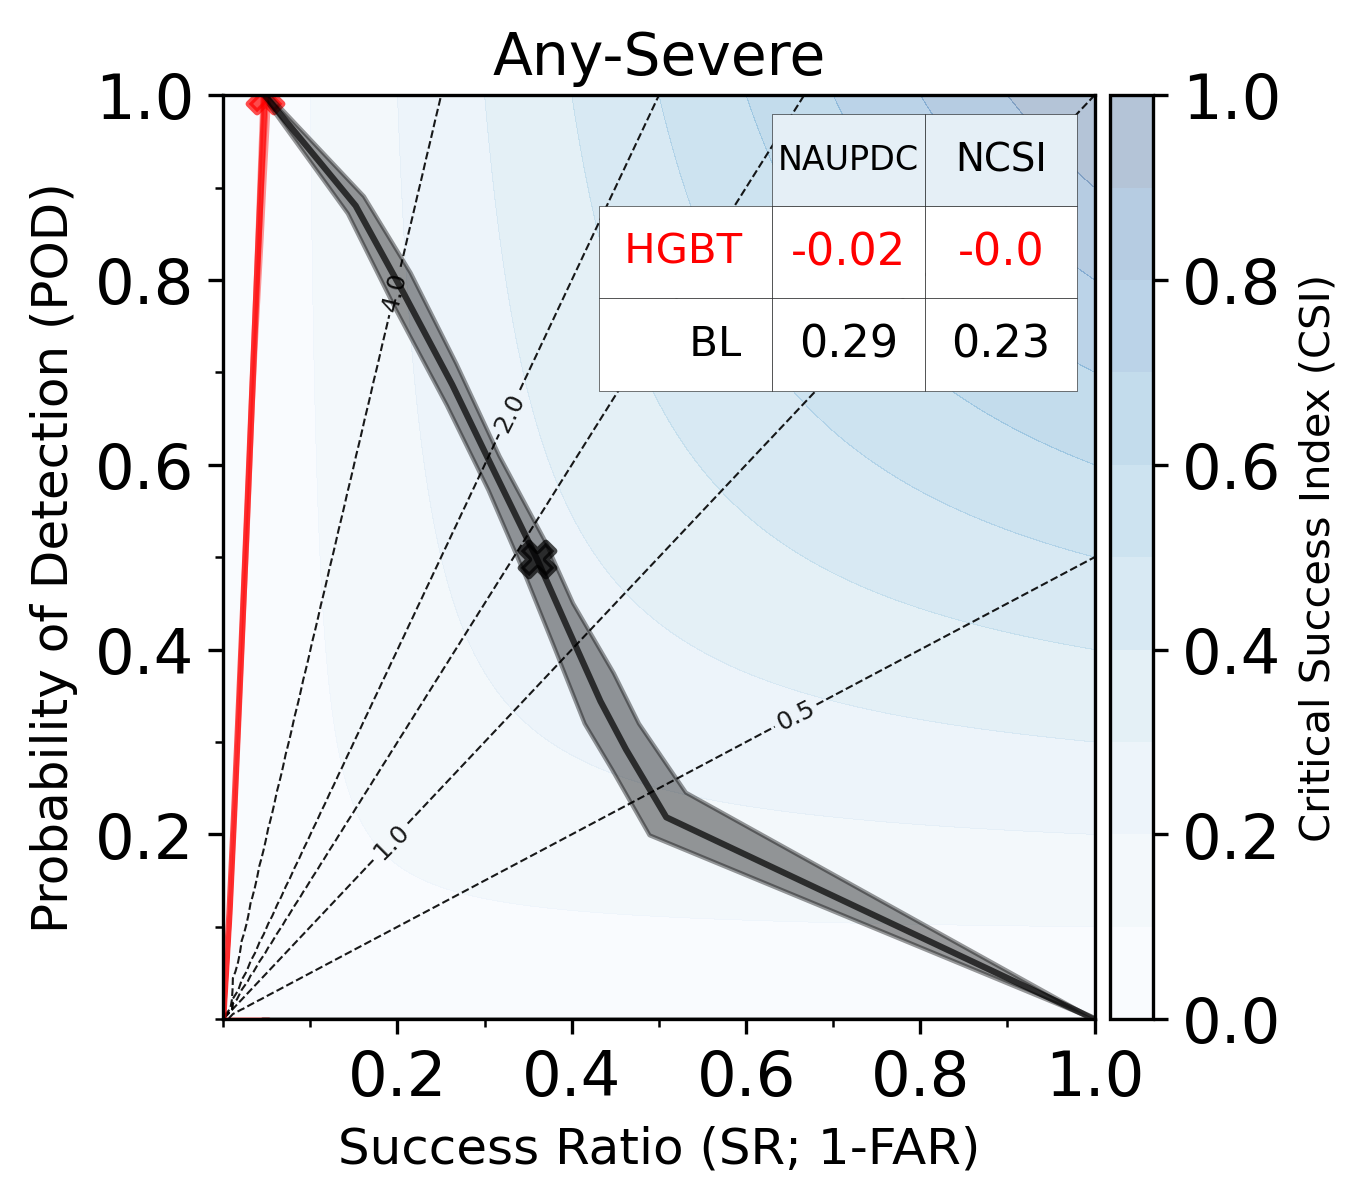

In [23]:
vd = VerificationDiagram()

ax = vd.plot('performance', _xx, _yy, scores=_scores,  add_dots=False, 
             add_max_marker=True, table_fontsize=10,  table_alpha=1, line_colors=colors,
            plot_kwargs={'line_colors':colors},
             table_bbox=[0.63, 0.68, 0.35, 0.3]
            )
#plt.savefig(f'/home/samuel.varga/{hazard}_comparison_performance.png', transparent=True, bbox_inches='tight')
#plt.title('Tornado', loc='right')
ax.set_title('Any-Severe', fontsize=14, pad=5)
plt.show() #.37, .27

# Reliability

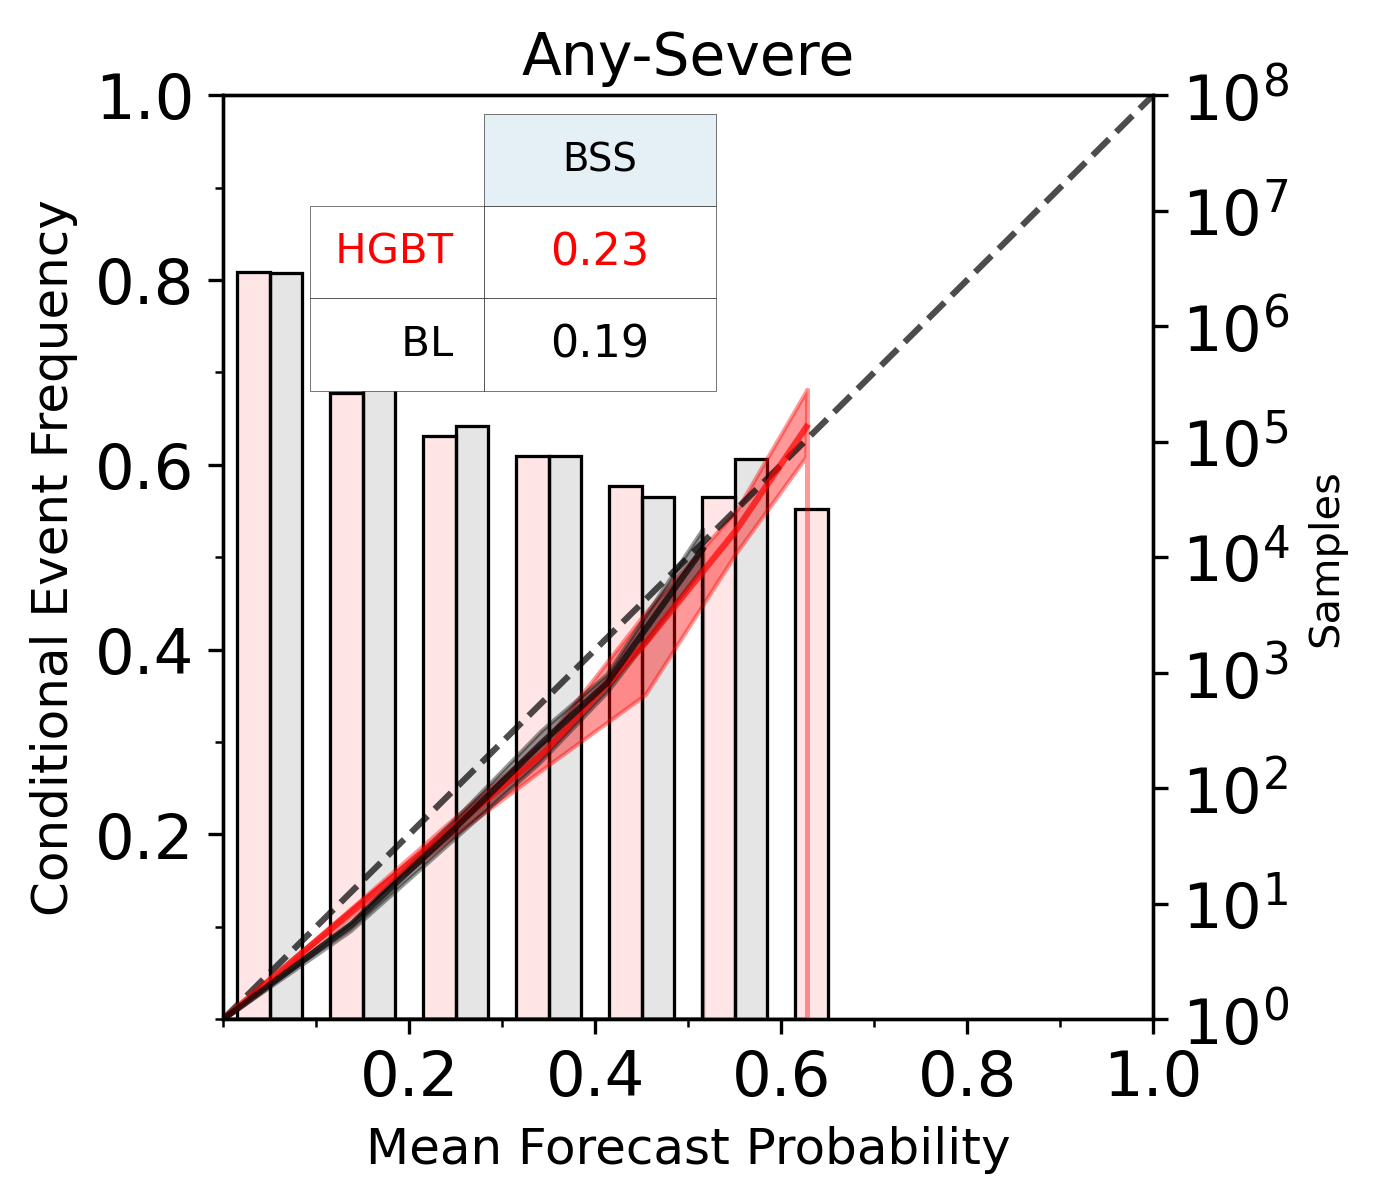

In [24]:
_xx={}
_yy={}
y_preds={}
for name, y_pred in zip([est[0] for est in estimators], y_hat):
    xx, yy, score = sklearn_curve_bootstrap(y.values, y_pred, metric='reliability', 
                                         n_boot=30, groups=groups, 
                                         #scorers={'AUPDC' : average_precision_score,
                                         #         'BSS' : brier_skill_score,
                                         #         'AUC' : roc_auc_score, 
                                         #        }, 
                            random_seed=42)
    y_preds[name]=y_pred
    _scores[name]=score
    for metric in score:
        full_scores[name][metric]=np.nanmean(score[metric])
    _xx[name]=xx
    _yy[name]=yy
    
vd = VerificationDiagram(y_pred=y_preds)
ax = vd.plot('reliability', _xx, _yy, scores=_scores, 
             #table_bbox=[0.46, 0.65, 0.1, 0.4],
             table_bbox=[0.28, 0.68, 0.25, 0.3],
             line_colors=colors, #0.28
            plot_kwargs={'line_colors':colors},table_fontsize=10, table_alpha=1, add_dots=False)

#plt.savefig(f'/home/samuel.varga/{hazard}_comparison_reliability.png', transparent=True, bbox_inches='tight')
ax.set_title('Any-Severe', fontsize=14, pad=5)
plt.show()

# ROC

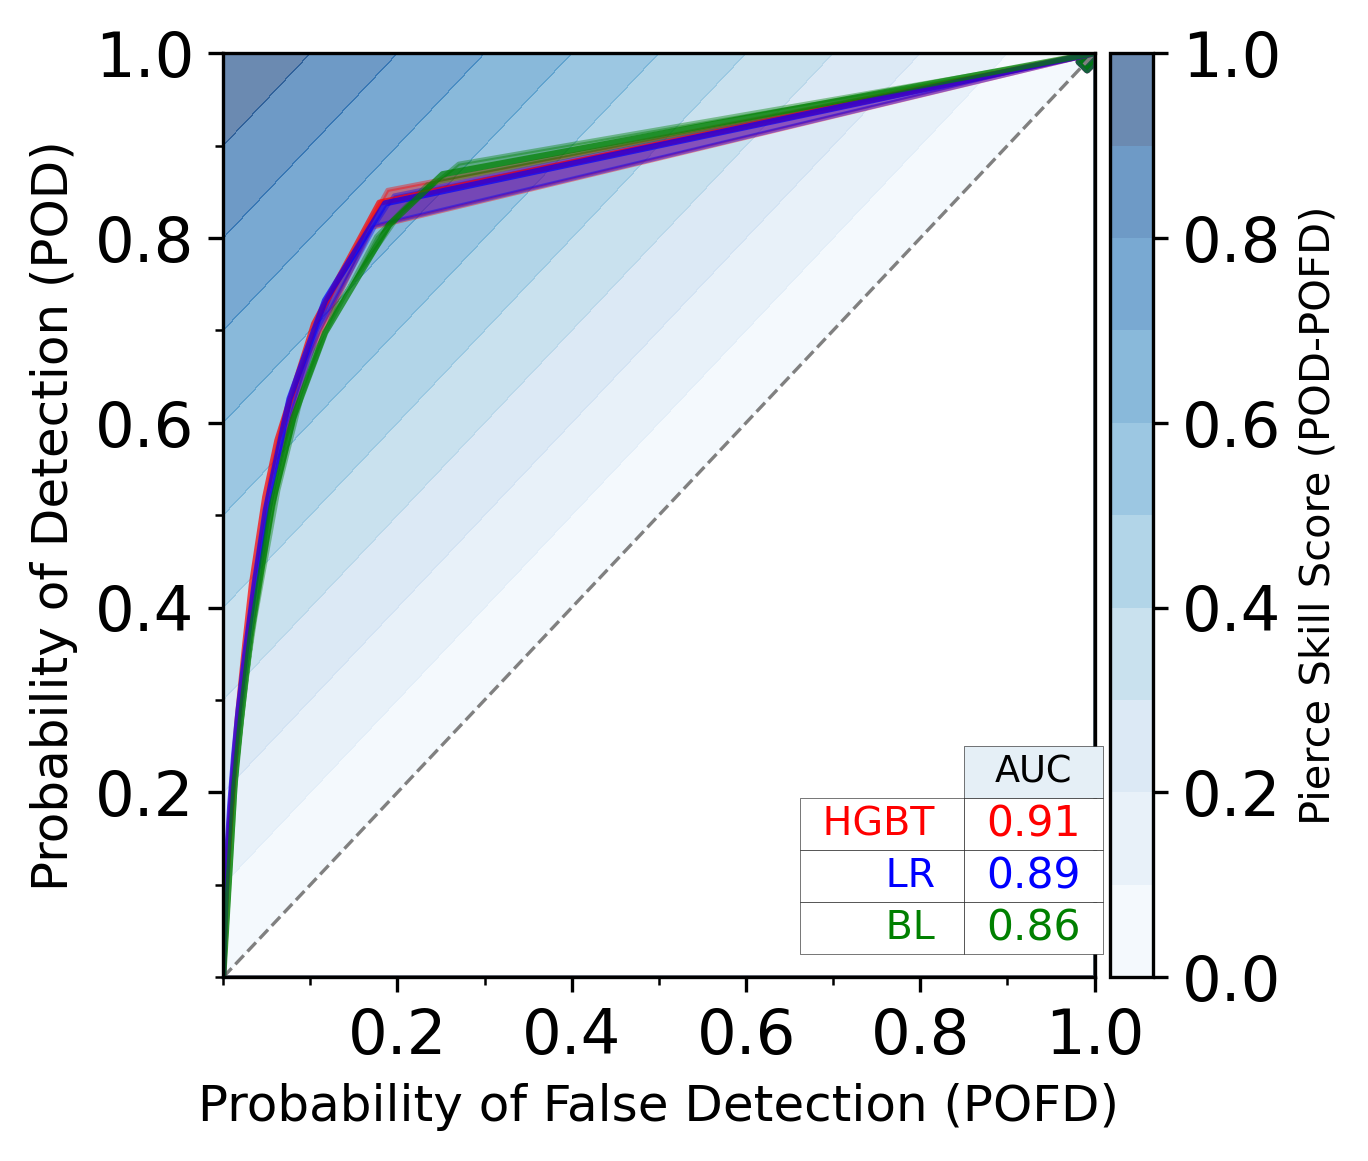

In [19]:
_xx={}
_yy={}
y_preds={}
for name, y_pred in zip([est[0] for est in estimators], y_hat):
    xx, yy, score = sklearn_curve_bootstrap(y.values, y_pred, metric='roc', 
                                         n_boot=30, groups=groups, 
                            random_seed=42)
    y_preds[name]=y_pred
    _scores[name]=score
    for metric in score:
        full_scores[name][metric]=np.nanmean(score[metric])
    _xx[name]=xx
    _yy[name]=yy

vd = VerificationDiagram()

vd.plot('roc', _xx, _yy, scores=_scores, add_dots=False, add_max_marker=True, plot_kwargs={'line_colors':['r','b','g','k']},table_fontsize=9.5, table_alpha=1 )

#plt.savefig(f'/home/samuel.varga/{hazard}_roc.png', transparent=True, bbox_inches='tight')
plt.show()

# Strat Verif

In [ ]:
y_all = y.values
y_hail = load_ml_data(base_path=data_path, mode=mode, target_col=f'hail_severe__{scale}', FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE, full_9km=full_9k)[1].values
y_wind = load_ml_data(base_path=data_path, mode=mode, target_col=f'wind_severe__{scale}', FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE, full_9km=full_9k)[1].values
y_torn = load_ml_data(base_path=data_path, mode=mode, target_col=f'tornado_severe__{scale}', FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE,  full_9km=full_9k)[1].values
y_dic={'all':y_all, 'wind':y_wind, 'hail':y_hail, 'tornado':y_torn}
metadata['Year']=[r_d[0:4] for r_d in metadata['Run Date']]

In [19]:
from scipy.ndimage import gaussian_filter

def practically_perfect_hindcast(y_true, meta=metadata, sigma=3.0):
    '''Takes in the True targets and creates a PPH for each init time
       Returns 1D array corresponding to PPH fields of y_true
    '''
    #1D Array that stores PPH values
    perfect=np.array([])
    
    for group in meta.groupby(['Run Date','Init Time']):
        #print(group)

        #Get domain shape
        shape=(len(np.unique(group[1]['NY'])), len(np.unique(group[1]['NX'])))
        #print(shape)

        #Get targets and reshape into 2D field
        group_inds = group[1].index.values
        field = np.array(y_true[group_inds], dtype='float')
        nd_field = field.reshape(shape)

        #Get PPH
        pph = gaussian_filter(nd_field, sigma)
        
        #Flatten back to 1D and append to the main array
        perfect=np.append(perfect, pph.flatten())
    
    return perfect

pph_dic = {'all':practically_perfect_hindcast(y_all),
           'wind':practically_perfect_hindcast(y_wind),
           'hail':practically_perfect_hindcast(y_hail),
           'tornado':practically_perfect_hindcast(y_torn)} # partial to save pph, how to update for specific hazards?

In [78]:
inds = {'2018':metadata[metadata['Year']=='2018'].index.values,
        '2019':metadata[metadata['Year']=='2019'].index.values,
        '2020':metadata[metadata['Year']=='2020'].index.values,
        '2021':metadata[metadata['Year']=='2021'].index.values}

In [17]:
yearly_all=[y_all[inds[group]] for group in inds.keys()]
yearly_wind=[y_wind[inds[group]] for group in inds.keys()]
yearly_hail=[y_hail[inds[group]] for group in inds.keys()]
yearly_torn=[y_torn[inds[group]] for group in inds.keys()]

In [ ]:
event_totals=[[year.sum()/1000 for year in yearly_all], [year.sum()/1000 for year in yearly_wind], [year.sum()/1000 for year in yearly_hail], [year.sum()/1000 for year in yearly_torn]]
yearly_totals={key:value for (key,value) in zip(['2018','2019','2020','2021'], np.array(event_totals).transpose())}
event_totals
#event_totals['all'] 
#Note: the events are not mutually exclusive, which is why all-severe is not the sum of wind+hail+tornado

In [ ]:
yearly_totals

In [ ]:
_scores={'2018':{},'2019':{},'2020':{},'2021':{}}
#AUC, AUPDC, BSS, Max CSI


import itertools
for year, (name, y_pred) in itertools.product(['2018','2019','2020','2021'], zip([est[0] for est in estimators], y_hat)):
    print(year, name)
    scores={}
    
    score= sklearn_curve_bootstrap(np.array(y.values)[inds[year]], np.array(y_pred)[inds[year]], metric='roc', 
                                         n_boot=30, groups=groups[inds[year]], 
                            random_seed=42)[2]
    for metric in score:
        scores[metric]=np.nanmean(score[metric])
    score= sklearn_curve_bootstrap(np.array(y.values)[inds[year]], np.array(y_pred)[inds[year]], metric='performance', 
                                         n_boot=30, groups=groups[inds[year]], 
                            random_seed=42)[2]
    for metric in score:
        scores[metric]=np.nanmean(score[metric])
    score= sklearn_curve_bootstrap(np.array(y.values)[inds[year]], np.array(y_pred)[inds[year]], metric='reliability', 
                                         n_boot=30, groups=groups[inds[year]], 
                            random_seed=42)[2]
    for metric in score:
        scores[metric]=np.nanmean(score[metric])
    
    _scores[year][name]=scores

In [ ]:
from functools import partial
from sklearn.metrics import log_loss
full_scores={'HGBT':{},'Full LR':{}, 'Sub LR':{}, 'BL':{}}
for name, y_pred in zip([est[0] for est in estimators], y_hat):
    
    full_scores[name]['bss']=brier_skill_score(y_all, y_pred)
    full_scores[name]['log_loss']=log_loss(y_all, y_pred)
    full_scores[name]['auc']=roc_auc_score(y_all, y_pred)
    full_scores[name]['csi']=max_csi(y_all, y_pred, np.mean(y_all))['MAX_CSI']
    average_precision = partial(_binary_uninterpolated_average_precision,
                                    known_skew=np.mean(y_all),
                                    new_skew=np.mean(y_all),
                                    pos_label=1)
    full_scores[name]['aupdc']= _average_binary_score(average_precision, y_all, y_pred, average='macro')
full_scores

In [ ]:
import matplotlib.patches as patches
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(8,8))
leg_handles=[patches.Patch(color=color, label=label) for (color, label) in zip(['blue','green','red'],['Wind','Hail','Torn'])]
for (color, label) in zip(['grey','brown','black'],['BSS','NCSI','NAUPDC']):
    leg_handles.append(Line2D([0],[0], marker='o',color='w',markerfacecolor=color, label=label, markersize=10))

mod_name='HGBT'
n_years=4
x_ticks=np.arange(n_years)
width=0.1
#all_bar=ax.bar(x_ticks-1.5*width, event_totals[0], width)

ax2=ax.twinx()
ax2.set_zorder(0)
wind=ax2.bar(x_ticks-1*width, event_totals[1], width, label='Wind', color='blue')
hail=ax2.bar(x_ticks+0*width, event_totals[2], width, label='Hail', color='green')
torn=ax2.bar(x_ticks+1*width, event_totals[3], width, label='Torn', color='red')
ax2.set_ylabel(r'Number of Targets ($10^{3}$)', fontsize=18)


ax.set_zorder(1)
bss=ax.plot(x_ticks, [_scores[year][mod_name]['bss'] for year in _scores.keys()], '-o', color='grey', label='BSS')
ncsi=ax.plot(x_ticks, [_scores[year][mod_name][''] for year in _scores.keys()], '-o', color='brown', label='NCSI')
naupdc=ax.plot(x_ticks, [_scores[year][mod_name]['NAUPDC'] for year in _scores.keys()], '-o', color='black', label='NAUPDC')


#Full dataset rates
ax.axhline(full_scores[mod_name]['BSS'], color='grey', ls='--')
ax.axhline(full_scores[mod_name]['NCSI'], color='brown', ls='--')
ax.axhline(full_scores[mod_name]['NAUPDC'], color='black', ls='--')
#any, hail, wind, tornado

ax.set_ylim([0,0.5])
ax.set_xticks(x_ticks)
ax.set_facecolor("none")
ax2.set_facecolor('white')
ax.set_xticklabels(['2018','2019','2020','2021'])
ax.set_ylabel('Metric', fontsize=18)
ax.set_title(f'Any-Sev {mod_name} Performance & No. of Targets by Year', fontsize=18)
plt.legend(handles=leg_handles, ncol=2)
plt.show()

In [ ]:
hourly_inds = {'1700':metadata[metadata['Init Time']=='1700'].index.values,
        '1800':metadata[metadata['Init Time']=='1800'].index.values,
       '1900':metadata[metadata['Init Time']=='1900'].index.values,
        '2000':metadata[metadata['Init Time']=='2000'].index.values,
       '2100':metadata[metadata['Init Time']=='2100'].index.values,
       '2200':metadata[metadata['Init Time']=='2200'].index.values,
       '2300':metadata[metadata['Init Time']=='2300'].index.values,
       '0000':metadata[metadata['Init Time']=='0000'].index.values,
       '0100':metadata[metadata['Init Time']=='0100'].index.values,
       '0200':metadata[metadata['Init Time']=='0200'].index.values,
       '0300':metadata[metadata['Init Time']=='0300'].index.values}
hourly_all=[y_all[hourly_inds[group]] for group in hourly_inds.keys()]
hourly_wind=[y_wind[hourly_inds[group]] for group in hourly_inds.keys()]
hourly_hail=[y_hail[hourly_inds[group]] for group in hourly_inds.keys()]
hourly_torn=[y_torn[hourly_inds[group]] for group in hourly_inds.keys()]
event_totals_hourly=[[hour.sum()/1000 for hour in hourly_all],[hour.sum()/1000 for hour in hourly_wind], [hour.sum()/1000 for hour in hourly_hail],[hour.sum()/1000 for hour in hourly_torn]]
event_rates_hourly=[[hour.sum()*100/len(hour) for hour in hourly_all],[hour.sum()*100/len(hour) for hour in hourly_wind], [hour.sum()*100/len(hour) for hour in hourly_hail],[hour.sum()*100/len(hour) for hour in hourly_torn]]
hourly_totals={key:value for (key,value) in zip(['1700','1800','1900','2000','2100','2200','2300','0000','0100','0200','0300'], np.array(event_totals_hourly).transpose())}

In [ ]:
grouped_inds={'17-18': np.append(hourly_inds['1700'], hourly_inds['1800']),
    '19-21':np.append(hourly_inds['1900'], [hourly_inds['2000'],hourly_inds['2100']]),
    '22-00':np.append(hourly_inds['2200'], [hourly_inds['2300'],hourly_inds['0000']]),
    '01-03':np.append(hourly_inds['0100'], [hourly_inds['0200'],hourly_inds['0300']])}
grouped_all=[y_all[grouped_inds[group]] for group in grouped_inds.keys()]
grouped_wind=[y_wind[grouped_inds[group]] for group in grouped_inds.keys()]
grouped_hail=[y_hail[grouped_inds[group]] for group in grouped_inds.keys()]
grouped_torn=[y_torn[grouped_inds[group]] for group in grouped_inds.keys()]
event_rates_grouped=[[hour.sum()*100/len(hour) for hour in grouped_all],[hour.sum()*100/len(hour) for hour in grouped_wind], [hour.sum()*100/len(hour) for hour in grouped_hail],[hour.sum()*100/len(hour) for hour in grouped_torn]]

In [ ]:

hourly_scores={'1700':{},'1800':{},'1900':{},'2000':{},'2100':{},'2200':{},'2300':{},'0000':{},'0100':{},'0200':{},'0300':{}}
#AUC, AUPDC, BSS, Max CSI


import itertools
for year, (name, y_pred) in itertools.product(['1700','1800','1900','2000','2100','2200','2300','0000','0100','0200','0300'], zip([est[0] for est in estimators], y_hat)):
    print(year, name)
    scores={}
    
    score= sklearn_curve_bootstrap(np.array(y.values)[hourly_inds[year]], np.array(y_pred)[hourly_inds[year]], metric='roc', 
                                         n_boot=30, groups=groups[hourly_inds[year]], 
                            random_seed=42)[2]
    for metric in score:
        scores[metric]=np.nanmean(score[metric])
    score= sklearn_curve_bootstrap(np.array(y.values)[hourly_inds[year]], np.array(y_pred)[hourly_inds[year]], metric='performance', 
                                         n_boot=30, groups=groups[hourly_inds[year]], 
                            random_seed=42)[2]
    for metric in score:
        #print(len(score[metric]))
        scores[metric]=np.nanmean(score[metric])
    score= sklearn_curve_bootstrap(np.array(y.values)[hourly_inds[year]], np.array(y_pred)[hourly_inds[year]], metric='reliability', 
                                         n_boot=30, groups=groups[hourly_inds[year]], 
                            random_seed=42)[2]
    for metric in score:
        scores[metric]=np.nanmean(score[metric])
    
    hourly_scores[year][name]=scores

In [ ]:
grouped_hourly_scores={'17-18':{},'19-21':{},'22-00':{},'01-03':{}}
#AUC, AUPDC, BSS, Max CSI


import itertools
for year, (name, y_pred) in itertools.product(['17-18','19-21','22-00','01-03'], zip([est[0] for est in estimators], y_hat)):
    print(year, name)
    scores={}
    
    #score= sklearn_curve_bootstrap(np.array(y.values)[grouped_inds[year]], np.array(y_pred)[grouped_inds[year]], metric='roc', 
    #                                     n_boot=30, groups=groups[grouped_inds[year]], 
    #                        random_seed=42)[2]
    #for metric in score:
    #    scores[metric]=np.nanmean(score[metric])
    scores['bss']=brier_skill_score(y_all[grouped_inds[year]], y_pred[grouped_inds[year]])
    scores['auc']=roc_auc_score(y_all[grouped_inds[year]], y_pred[grouped_inds[year]])
    scores['csi']=max_csi(y_all[grouped_inds[year]], y_pred[grouped_inds[year]], np.mean(y_all[grouped_inds[year]]))['MAX_CSI']
    
    average_precision = partial(_binary_uninterpolated_average_precision,
                                    known_skew=np.mean(y_all[grouped_inds[year]]),
                                    new_skew=np.mean(y_all[grouped_inds[year]]),
                                    pos_label=1)
    scores['aupdc']= _average_binary_score(average_precision, y_all[grouped_inds[year]], y_pred[grouped_inds[year]], average='macro')
    
    
    #score= sklearn_curve_bootstrap(np.array(y.values)[grouped_inds[year]], np.array(y_pred)[grouped_inds[year]], metric='performance', 
    #                                     n_boot=30, groups=groups[grouped_inds[year]], 
    #                        random_seed=42)[2]
    #for metric in score:
    #    scores[metric]=np.nanmean(score[metric])
    #score= sklearn_curve_bootstrap(np.array(y.values)[grouped_inds[year]], np.array(y_pred)[grouped_inds[year]], metric='reliability', 
    #                                     n_boot=30, groups=groups[grouped_inds[year]], 
    #                        random_seed=42)[2]
    #for metric in score:
    #    scores[metric]=np.nanmean(score[metric])
    
    grouped_hourly_scores[year][name]=scores

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,8))
leg_handles=[patches.Patch(color=color, label=label) for (color, label) in zip(['black','blue','orange','red'],['Any','Wind','Hail','Torn'])]
for (color, label) in zip(['grey','brown','black'],['BSS','Max CSI','AUPDC']):
    leg_handles.append(Line2D([0],[0], marker='o',color='w',markerfacecolor=color, label=label, markersize=10))

n_years=4
x_ticks=np.arange(n_years)
width=0.2
#all_bar=ax.bar(x_ticks-1.5*width, event_totals[0], width)

ax2=ax.twinx()
ax2.set_zorder(0)
any_=ax2.bar(x_ticks-1.5*width, event_rates_grouped[0], width, label='Any', color='black')
wind=ax2.bar(x_ticks-0.5*width, event_rates_grouped[1], width, label='Wind', color='blue')
hail=ax2.bar(x_ticks+0.5*width, event_rates_grouped[2], width, label='Hail', color='orange')
torn=ax2.bar(x_ticks+1.5*width, event_rates_grouped[3], width, label='Torn', color='red')
ax2.set_ylabel(r'Event Rate (%)', fontsize=18)


ax.set_zorder(1)
bss=ax.plot(x_ticks, [grouped_hourly_scores[year][mod_name]['bss'] for year in grouped_hourly_scores.keys()], '-o', color='grey', label='BSS')
ncsi=ax.plot(x_ticks, [grouped_hourly_scores[year][mod_name]['csi'] for year in grouped_hourly_scores.keys()], '-o', color='brown', label='NCSI')
naupdc=ax.plot(x_ticks, [grouped_hourly_scores[year][mod_name]['aupdc'] for year in grouped_hourly_scores.keys()], '-o', color='black', label='NAUPDC')


#Full dataset rates
ax.axhline(full_scores[mod_name]['bss'], color='grey', ls='--')
ax.axhline(full_scores[mod_name]['csi'], color='brown', ls='--')
ax.axhline(full_scores[mod_name]['aupdc'], color='black', ls='--')

ax.set_ylim([0,0.5])
ax.set_xticks(x_ticks)
ax.set_facecolor("none")
ax2.set_facecolor('white')
#ax.set_xticklabels(['1700','1800','1900','2000','2100','2200','2300','0000','0100','0200','0300'])
ax.set_xticklabels(['19-02','21-03','00-06','03-09'])
ax.set_ylabel('Metric Score', fontsize=18)
ax.set_xlabel('Valid Time (UTC)', fontsize=18)
ax.set_title(f'Any-Severe {mod_name} Performance & Event Rate', fontsize=18)
plt.legend(handles=leg_handles, ncol=2)
plt.show()

#Change to v_time, group times

# Scatter plot

In [20]:
def practically_perfect_scorer(pph, y_predicted):
    '''Calculates the MSE between PPH fields of y_true and y_predicted'''
    '''PPH fields are calculated beforehand to avoid issues with grouping'''
    
    #Return MSE
    squared_error = (pph - y_predicted)**2
    
    return np.nanmean(squared_error)

In [8]:
def aupdc_scorer(y_true, y_predicted):
    average_precision = partial(_binary_uninterpolated_average_precision,
                                    known_skew=np.mean(y_true),
                                    new_skew=np.mean(y_true),
                                    pos_label=1)
    return _average_binary_score(average_precision, y_true, y_predicted, average='macro')

In [9]:
from functools import partial
from sklearn.metrics import log_loss, brier_score_loss, balanced_accuracy_score, average_precision_score, accuracy_score, precision_score, f1_score, recall_score
scorers={'bss':brier_skill_score, #'auc':roc_auc_score,
         #'log_loss':log_loss,
         'reliability':bss_reliability, 'max_csi':max_csi, 'aupdc':aupdc_scorer,
        'brier_loss':brier_score_loss, 'resolution': bss_resolution, 
         'average_precision':average_precision_score, #'pph':practically_perfect_scorer
        }

In [20]:
def get_percentile_mask(maskby, p):
    '''Returns a boolean array that is true where any element of maskby>p'''
    masks=[]
    final_mask=np.zeros_like(maskby[0], dtype='bool')
    
    for mask in maskby:
        final_mask=np.ma.mask_or(final_mask, (mask >= p))
    return final_mask

import pickle 
from os.path import join
    
def get_masked_percentile_metrics(predlist, p, maskby, scorers=scorers, y_dic=y_dic, cv=None, fname=None):
    '''Masks all values < p, then calculates performance metrics on unmasked values for all models in modlist''' #Use indices to avoid masking issues in statistical functions
    '''Predlist: list of (mod_dic, predictions); elements in axis 0 correspond to different models'''
    '''p: percentile threshold. Values < p are ignored when calculating metrics'''
    '''maskby: Dic. of list of prediction arrays; mask is generated using the union of where each element in axis 0 has values >= p '''
    '''fname: tuple of (path, fname)'''
    mask_scores=[]
    #Get indices where any prediction in maskby is >=p
    if p<=0 or maskby==None:
        print('P<=0 or Maskby is None: Not masking')
        mask={key : np.ones_like(predlist[0][1], dtype='bool') for key in ['all', 'wind','hail','tornado']}
    else:
        mask = {str(key) : get_percentile_mask(maskby[key], p).nonzero()[0] for key in maskby.keys()}
        print(f'Masking values <={p}: {[len(mask[m]) for m in mask]} values remain')
              
    for (mod, predictions) in predlist:
        try: #Gets rid of the model to save space
            mod.pop('model')
        except:
            pass
        mask_scores.append((mod, sklearn_curve_bootstrap(y_dic[mod['hazard']][mask[mod['hazard']]], predictions[mask[mod['hazard']]], metric='reliability', pph=None, n_boot=15, scorers=scorers, groups=cv[mask[mod['hazard']]] if cv else None)[-1]))
        #pph_dic[mod['hazard']][mask[mod['hazard']]]
    
    if fname:
        with open(join(fname[0],fname[1]+f'{p:.2f}'),'wb') as f:
            print(f'Saving scores for p={p} at {fname[0]}/{fname[1]}{p:.2f}')
            pickle.dump(mask_scores,  f)
        
    return mask_scores

In [9]:
scales=['all', '9km', '27km', '45km']
categories=['control','environment','intrastorm']
haz_names=['all','wind','hail','tornado']
mod_names=['logistic','hist']

In [22]:
mod_list=[]

for mod_nam, scale, cat, haz_name in itertools.product(mod_names, scales, categories, haz_names):
    try:
        mod_list.append(load_ml_model({'name':mod_nam, 'train':scale, 'hazard':haz_name, 'targ_scale':'36km', 'suffix':cat}))
    except:
        print(f'Missing: {mod_nam} {scale} {cat} {haz_name}')

Missing: hist all control hail
Missing: hist all control tornado
Missing: hist all environment wind
Missing: hist all environment hail
Missing: hist all environment tornado
Missing: hist all intrastorm all
Missing: hist all intrastorm wind
Missing: hist all intrastorm hail
Missing: hist all intrastorm tornado
Missing: hist 9km control all
Missing: hist 9km control wind
Missing: hist 9km control hail
Missing: hist 9km control tornado
Missing: hist 9km environment all
Missing: hist 9km environment wind
Missing: hist 9km environment hail
Missing: hist 9km environment tornado
Missing: hist 9km intrastorm all
Missing: hist 9km intrastorm wind
Missing: hist 9km intrastorm hail
Missing: hist 9km intrastorm tornado
Missing: hist 27km control all
Missing: hist 27km control wind
Missing: hist 27km control hail
Missing: hist 27km control tornado
Missing: hist 27km environment all
Missing: hist 27km environment wind
Missing: hist 27km environment hail
Missing: hist 27km environment tornado
Missing

In [ ]:
scores={}
i=0
for mod_nam, scale, cat, haz_name in itertools.product(mod_names, scales, categories, haz_names):
    try:
        print('Loading Model')
        mod_dic = load_ml_model({'name':mod_nam, 'train':scale, 'hazard':haz_name, 'targ_scale':'36km', 'suffix':cat})
        X_s=Drop_Unwanted_Variables(X, original=False, training_scale=None if mod_dic['train']=='all' else mod_dic['train'][0:-2:1], intrastormOnly=True if mod_dic['suffix']=='intrastorm' else False, envOnly=True if mod_dic['suffix']=='environment' else False)[0]
        model = mod_dic.pop('model')
        print('Genning scores')
        scores[f'{mod_nam}_{scale}_{cat}_{haz_name}']=(mod_dic, sklearn_curve_bootstrap(y_dic[mod_dic['hazard']], get_ml_pred(X_s, model), metric='reliability', pph=None, n_boot=30, scorers=scorers, groups=groups, )[-1])
    except:
        print(f'Missing: {mod_nam} {scale} {cat} {haz_name}')
    
    print(i)
    
    if i==0:
        with open(join('/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/scores','full_scores.pkl'),'wb') as f:
            pickle.dump(scores,  f)
    elif i%5==0:
        print('Saving Scores')
        with open(join('/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/scores','full_scores.pkl'),'rb') as f:
            scores.update(pickle.load(f)) #Load the previous scores and add the extra 5
        with open(join('/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/scores','full_scores.pkl'),'wb') as f:
            pickle.dump(scores,  f) #Save the scores and clear them
        scores={}
    i+=1
    

Loading Model
Using new variables- dropping old 90th percentile
(2128224, 174)
all
Genning scores
0
Loading Model
Using new variables- dropping old 90th percentile
(2128224, 174)
all
Genning scores
1
Loading Model
Using new variables- dropping old 90th percentile
(2128224, 174)
all
Genning scores
2
Loading Model
Using new variables- dropping old 90th percentile
(2128224, 174)
all
Genning scores
3
Loading Model
Using new variables- dropping old 90th percentile
Dropping all intrastorm variables
(2128224, 78)
all
Genning scores
4
Loading Model
Using new variables- dropping old 90th percentile
Dropping all intrastorm variables
(2128224, 78)
all
Genning scores
5
Saving Scores
Loading Model
Using new variables- dropping old 90th percentile
Dropping all intrastorm variables
(2128224, 78)
all
Genning scores
6
Loading Model
Using new variables- dropping old 90th percentile
Dropping all intrastorm variables
(2128224, 78)
all
Genning scores
7
Loading Model
Using new variables- dropping old 90th p

(2128224, 26)
9km
Genning scores
65
Saving Scores
Loading Model
Using new variables- dropping old 90th percentile
Dropping all intrastorm variables
(2128224, 26)
9km
Genning scores
66
Loading Model
Using new variables- dropping old 90th percentile
Dropping all intrastorm variables
(2128224, 26)
9km
Genning scores
67
Loading Model
Using new variables- dropping old 90th percentile
Dropping all environmental variables
(2128224, 32)
9km
Genning scores
68
Loading Model
Using new variables- dropping old 90th percentile
Dropping all environmental variables
(2128224, 32)
9km
Genning scores
69
Loading Model
Using new variables- dropping old 90th percentile
Dropping all environmental variables
(2128224, 32)
9km
Genning scores
70
Saving Scores
Loading Model
Using new variables- dropping old 90th percentile
Dropping all environmental variables
(2128224, 32)
9km
Genning scores
71
Loading Model
Using new variables- dropping old 90th percentile
(2128224, 58)
27km
Genning scores
72
Loading Model
Using

In [32]:
baseline_df_list=[get_bl_col('36', f'{hazard_}_severe', TIMESCALE) for hazard_ in ['all','wind','hail','tornado']]
bl_df_list=[bl_df[col] for col in baseline_df_list]
baseline_list=[joblib.load(join(f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/POTVIN', f'blModels/{haz}_baseline_model_36km.joblib')) for haz in ["all","wind","hail","tornado"]]

In [36]:
#Baseline Scores
bl_scores=[]
for bl_mod, bl_X, y_s, h in zip(baseline_list, bl_df_list, [y_all, y_wind, y_hail, y_torn], ['all','wind','hail','tornado']):
    preds = get_bl_pred(bl_X.values, ('BL',bl_mod))
    bl_scores.append(sklearn_curve_bootstrap(y_s, preds, pph=None, metric='reliability', n_boot=30, scorers=scorers, groups=groups)[-1])
    
with open(join('/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/scores','bl_full_scores.pkl'),'wb+') as f:
    pickle.dump(bl_scores,  f)

In [ ]:
import warnings
import pickle
warnings.filterwarnings(action='once')
daily_scores={}
bl_daily_scores={}

if False:
    for group in metadata.groupby(['Run Date']):
        print(group[0])
        group_inds=group[1].index.values
        temp_scores=[]
        bl_scores=[]

        for mod_dic in mod_list:
            X_s=Drop_Unwanted_Variables(X.iloc[group_inds], original=False, training_scale=None if mod_dic['train']=='all' else mod_dic['train'][0:-2:1], intrastormOnly=True if mod_dic['suffix']=='intrastorm' else False, envOnly=True if mod_dic['suffix']=='environment' else False)[0]
            model=mod_dic.pop('model')
            temp_scores.append((mod_dic, sklearn_curve_bootstrap(y_dic[mod_dic['hazard']][group_inds], get_ml_pred(X_s, model), metric='reliability', pph=pph_dic[mod_dic['hazard']][group_inds], n_boot=15, scorers=scorers, groups=None)[-1]))
            mod_dic['model']=model
        daily_scores[str(group[0])]=temp_scores

        for bl_mod, bl_X, h in zip(baseline_list, bl_df_list, ['all','wind','hail','tornado']):
            preds = get_bl_pred(bl_X[group_inds].values, ('BL',bl_mod))
            bl_scores.append(sklearn_curve_bootstrap(y_dic[h][group_inds], preds, pph=pph_dic[h][group_inds], metric='reliability', n_boot=15, scorers=scorers, groups=None)[-1])
        bl_daily_scores[str(group[0])]=bl_scores

    warnings.filterwarnings('default')
    with open(join('/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/scores','Daily_scores.pkl'),'wb') as f:
        pickle.dump(daily_scores,  f)
    with open(join('/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/scores','Daily_scores_bl.pkl'),'wb') as f:
        pickle.dump(bl_daily_scores,  f)

In [27]:
with open(join('/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/scores','Daily_scores.pkl'),'rb') as f:
    daily_scores=pickle.load(f)
with open(join('/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/scores','Daily_scores_bl.pkl'),'rb') as f:
    bl_daily_scores=pickle.load(f)

In [ ]:
case_scores=[]
for mod_dic in mod_list:
    
_y_dic={}
group_inds=metadata.groupby(['Run Date', 'Init Time']).get_group(('20190523','2000')).index.values
for y, h in zip([y_all, y_wind, y_hail, y_torn], ['all','wind','hail','tornado']):
    _y_dic[h]=y[group_inds]

In [4]:
#Category models and combo models
marker_colors={'control':'k','intrastorm':'#03a1fc','environment':'#fc6203', 
               'all':'k','wind':'blue','hail':'orange','tornado':'red'}
marker_shapes={'all':'o', '9km':'v','27km':'s','45km':'P'}
bl_inds={'all':0,'wind':1,'hail':2,'tornado':3}

In [5]:
met_labels={'bss':'Brier Skill Score','aupdc':'AUPDC','csi':'Max CSI','auc':'AUC', 'log_loss':'Log Loss', 'reliability':'BSS Reliability', 'resolution':'BSS Resolution','brier_loss':'Brier Loss', 'average_precision':'Average Precision', 'pph':'Practically Perfect MSE'}
x_met='bss'
y_met='aupdc'
pred_type=['control','intrastorm','environment']
pred_scale=['45km','all','27km','9km']
plot_mod=['logistic','hist']
plot_haz='all'

###
plot_date='20210523'
size=100
line_width=1
line_alpha=1
import matplotlib.patches as patches
from matplotlib.lines import Line2D

# Full Scores

In [6]:
import pickle
with open(join('/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/scores','full_scores.pkl'),'rb') as f:
    scores=pickle.load(f)
with open(join('/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/scores','bl_full_scores.pkl'),'rb') as f:
    bl_scores=pickle.load(f)

In [7]:
def set_ax_lims(ax, x_met, y_met):
    if x_met in ['reliability','brier_loss','resolution','pph']:
        ax.set_xlim(0,0.01) if x_met=='reliability' else ax.set_xlim(0,0.1)
    elif x_met=='auc':
        ax.set_xlim(0,1)
    else:
        ax.set_xlim(0.05,0.3)

    if y_met in ['reliability','brier_loss','resolution','pph']:
        ax.set_ylim(0,0.01) if y_met=='reliability' else ax.set_ylim(0,0.1)
    elif y_met=='auc':
        ax.set_ylim(0,1)
    elif y_met=='log_loss':
        ax.set_ylim(0,0.25)
    else:
        ax.set_ylim(0.15,0.45)
        #ax.set_ylim(0.25, 0.65)
    return None

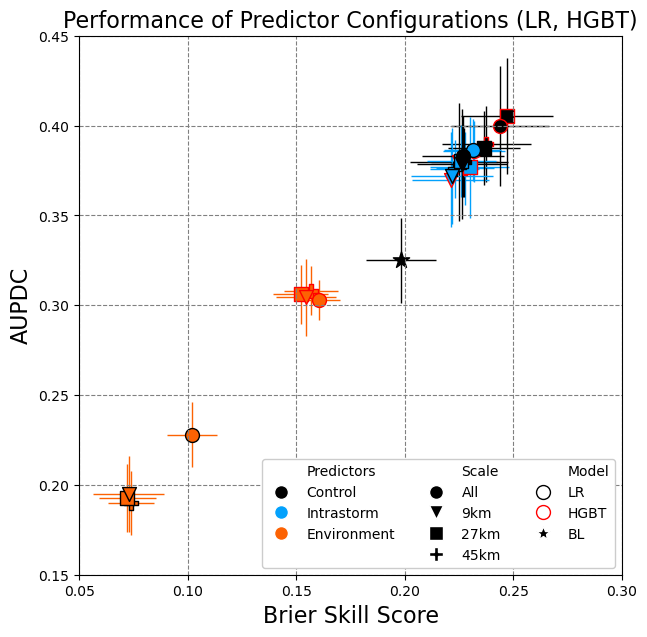

In [8]:
fig, ax = plt.subplots(figsize=(7,7))

for mod_name in scores.keys():
    if mod_name.split('_')[0] in plot_mod and mod_name.split('_')[1] in pred_scale and mod_name.split('_')[2] in pred_type and mod_name.split('_')[3] in plot_haz:
        ax.errorbar(np.nanmean(scores[mod_name][1][x_met]), np.nanmean(scores[mod_name][1][y_met]), xerr=2*np.std(scores[mod_name][1][x_met]), yerr=2*np.std(scores[mod_name][1][y_met]),
                    marker=None, linewidth=line_width, zorder=0, color=marker_colors[scores[mod_name][0]['suffix']])
        ax.scatter(np.nanmean(scores[mod_name][1][x_met]), np.nanmean(scores[mod_name][1][y_met]),
                  color=marker_colors[scores[mod_name][0]['suffix']], marker=marker_shapes[scores[mod_name][0]['train']], s=size,
                  edgecolor='red' if 'hist' in mod_name else 'k')
    else:
        pass
#Baseline
for b, color in zip(bl_scores, ['k','blue','orange','red']):
    if color in marker_colors[plot_haz]:
        ax.errorbar(np.nanmean(b[x_met]),np.nanmean(b[y_met]), xerr=2*np.std(b[x_met]), yerr=2*np.std(b[y_met]), color=color, marker=None, linewidth=line_width, zorder=0)
        ax.scatter(np.nanmean(b[x_met]), np.nanmean(b[y_met]), edgecolor='k', color=color, marker='*',  s=1.5*size)
    else:
        pass


    
ax.set_xlabel(met_labels[x_met], fontsize=16)
ax.set_ylabel(met_labels[y_met], fontsize=16)
set_ax_lims(ax, x_met, y_met)
ax.grid( color='grey', ls='--')
ax.set_title(f'Performance of Predictor Configurations ({"LR" if "logistic" in plot_mod else ""}{", " if len(plot_mod)==2 else ""}{"HGBT" if "hist" in plot_mod else ""})', fontsize=16)

leg_handles=[]
leg_handles.append(Line2D([0],[0], marker='*',color='w',markerfacecolor='w', label='Predictors', markersize=10))
for mark in marker_colors.keys():
    if mark not in ['all','wind','hail','tornado']:
        leg_handles.append(Line2D([0],[0], marker='o',color='w',markerfacecolor=marker_colors[mark], label=mark.capitalize(), markersize=10))

leg_handles.append(Line2D([0],[0], marker='*', markerfacecolor='w', color='w', label='', markersize=10))
leg_handles.append(Line2D([0],[0], marker='*',color='w',markerfacecolor='w', label='Scale', markersize=10))

for mark in marker_shapes.keys():
    leg_handles.append(Line2D([0],[0], marker=marker_shapes[mark], markerfacecolor='k', color='w', label=mark.capitalize(), markersize=10))
    

leg_handles.append(Line2D([0],[0], marker=marker_shapes[mark], markerfacecolor='w', color='w', label='Model', markersize=10))
leg_handles.append(Line2D([0],[0], marker='o', markeredgecolor='k', markerfacecolor='w', color='w', label='LR', markersize=10))
leg_handles.append(Line2D([0],[0], marker='o', markeredgecolor='red', markerfacecolor='w', color='w', label='HGBT', markersize=10))
leg_handles.append(Line2D([0],[0], marker='*',color='w',markerfacecolor='k', label='BL', markersize=10))
#leg_handles.append(Line2D([0],[0], marker=marker_shapes[mark], markerfacecolor='w', color='w', label='', markersize=10))
#leg_handles.append(Line2D([0],[0], marker=marker_shapes[mark], markerfacecolor='w', color='w', label='', markersize=10))
if y_met in ['reliability', 'log_loss','brier_loss','bss','pph']:
    plt.legend(handles=leg_handles, ncol=3, loc='upper right', framealpha=1)
else:
    plt.legend(handles=leg_handles, ncol=3, loc='lower right', framealpha=1) 
plt.show()

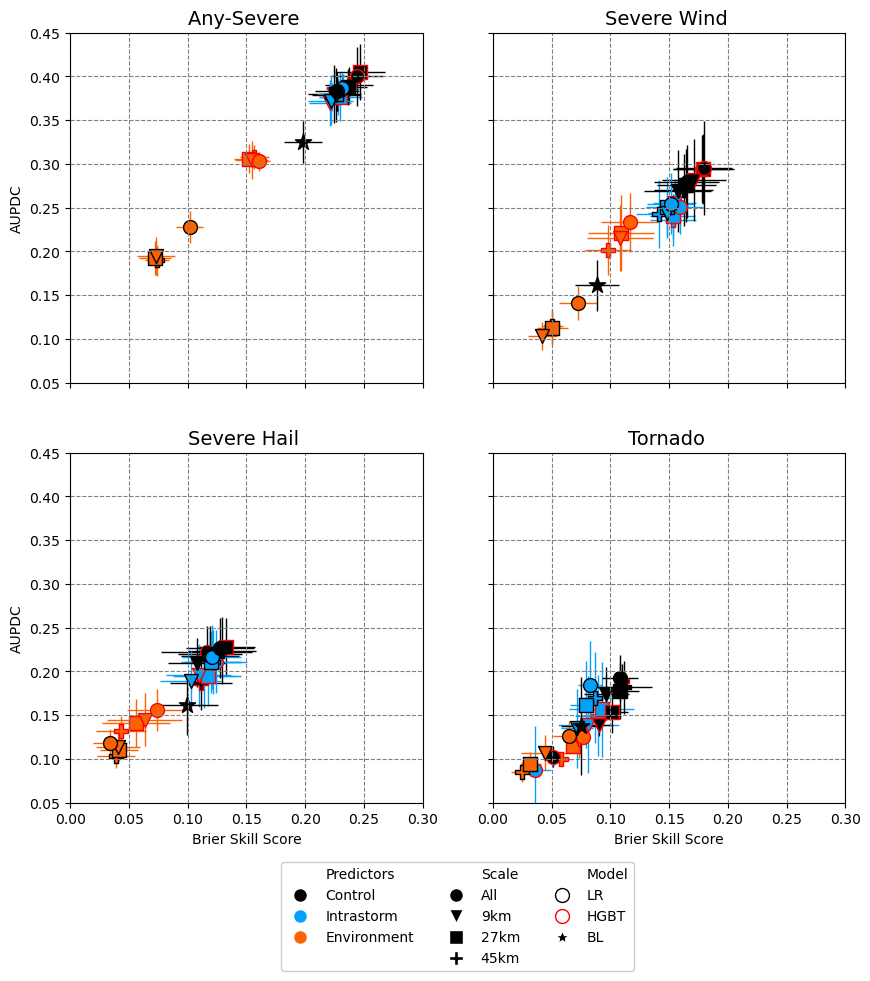

In [26]:
fig, ax = plt.subplots(figsize=(10,10), ncols=2, nrows=2, sharex='col', sharey='row')
for sub_ax, haz in zip(ax.flatten(), ['all','wind','hail','tornado']):
    for mod_name in scores.keys():
        if mod_name.split('_')[0] in plot_mod and mod_name.split('_')[1] in pred_scale and mod_name.split('_')[2] in pred_type and mod_name.split('_')[3] == haz:
            sub_ax.errorbar(np.nanmean(scores[mod_name][1][x_met]), np.nanmean(scores[mod_name][1][y_met]), xerr=2*np.std(scores[mod_name][1][x_met]), yerr=2*np.std(scores[mod_name][1][y_met]),
                        marker=None, linewidth=line_width, zorder=0, color=marker_colors[scores[mod_name][0]['suffix']])
            sub_ax.scatter(np.nanmean(scores[mod_name][1][x_met]), np.nanmean(scores[mod_name][1][y_met]),
                      color=marker_colors[scores[mod_name][0]['suffix']], marker=marker_shapes[scores[mod_name][0]['train']], s=size,
                      edgecolor='red' if 'hist' in mod_name else 'k')
        else:
            pass
    #Baseline
    for b, color in zip(bl_scores, ['k','blue','orange','red']):
        if color in marker_colors[haz]:
            sub_ax.errorbar(np.nanmean(b[x_met]),np.nanmean(b[y_met]), xerr=2*np.std(b[x_met]), yerr=2*np.std(b[y_met]), color='k', marker=None, linewidth=line_width, zorder=0)
            sub_ax.scatter(np.nanmean(b[x_met]), np.nanmean(b[y_met]), edgecolor='k', color='k', marker='*',  s=1.5*size)
        else:
            pass
    sub_ax.grid( color='grey', ls='--')
    sub_ax.set_ylim(0.05, 0.45)
    sub_ax.set_xlim(0, 0.30)
    sub_ax.set_title(f'{"Severe " if haz not in ["all","tornado"] else ""}{haz.capitalize() if haz!="all" else "Any-Severe"} ', fontsize=14)
    
for sub_ax in ax[1,:] :
    sub_ax.set_xlabel(met_labels[x_met])
    sub_ax.set_xlabel(met_labels[x_met])
for sub_ax in ax[:,0] :
    sub_ax.set_ylabel(met_labels[y_met])
    sub_ax.set_ylabel(met_labels[y_met])
    
    
    
    
    leg_handles=[]
leg_handles.append(Line2D([0],[0], marker='*',color='w',markerfacecolor='w', label='Predictors', markersize=10))
for mark in marker_colors.keys():
    if mark not in ['all','wind','hail','tornado']:
        leg_handles.append(Line2D([0],[0], marker='o',color='w',markerfacecolor=marker_colors[mark], label=mark.capitalize(), markersize=10))

leg_handles.append(Line2D([0],[0], marker='*', markerfacecolor='w', color='w', label='', markersize=10))
leg_handles.append(Line2D([0],[0], marker='*',color='w',markerfacecolor='w', label='Predictor Scale', markersize=10))

for mark in marker_shapes.keys():
    leg_handles.append(Line2D([0],[0], marker=marker_shapes[mark], markerfacecolor='k', color='w', label=mark.capitalize(), markersize=10))
    

leg_handles.append(Line2D([0],[0], marker=marker_shapes[mark], markerfacecolor='w', color='w', label='Model', markersize=10))
leg_handles.append(Line2D([0],[0], marker='o', markeredgecolor='k', markerfacecolor='w', color='w', label='LR', markersize=10))
leg_handles.append(Line2D([0],[0], marker='o', markeredgecolor='red', markerfacecolor='w', color='w', label='HGBT', markersize=10))
leg_handles.append(Line2D([0],[0], marker='*',color='w',markerfacecolor='k', label='BL', markersize=10))

plt.legend(handles=leg_handles, ncol=3, framealpha=1, bbox_to_anchor=(0.42,-0.15))
plt.show()

# Daily Scores

NameError: name 'daily_scores' is not defined

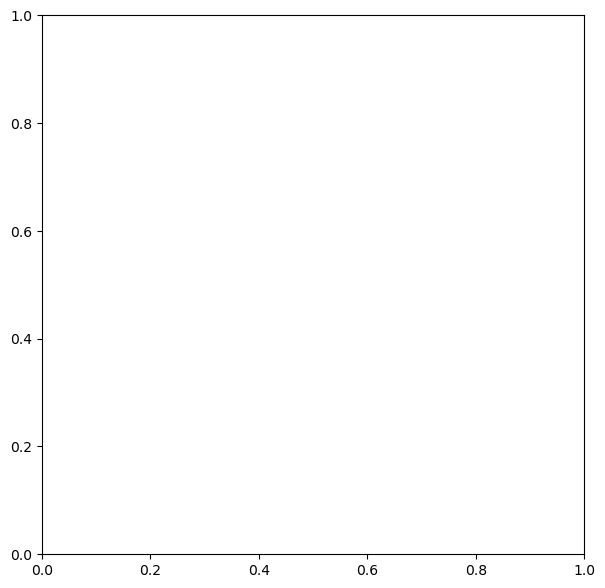

In [43]:
fig, ax = plt.subplots(figsize=(7,7))

#for mod, score in zip(mod_list, scores):
for (mod, score) in daily_scores[plot_date]:
    if mod['suffix'] in pred_type and mod['name'] in plot_mod:
        ax.errorbar(np.nanmean(score[x_met]),np.nanmean(score[y_met]), xerr=2*np.std(score[x_met]), yerr=2*np.std(score[y_met]), color=marker_colors[mod['hazard']], marker=None, linewidth=line_width, zorder=0)
        ax.scatter(np.nanmean(score[x_met]), np.nanmean(score[y_met]), color=marker_colors[mod['hazard']], marker=marker_shapes[mod['train']], s=size, edgecolor='red' if mod['name']=='hist' else 'k')
    else:
        pass

#Baseline
for b, color in zip(bl_daily_scores[plot_date], ['k','blue','orange','red']):
    ax.errorbar(np.nanmean(b[x_met]),np.nanmean(b[y_met]), xerr=2*np.std(b[x_met]), yerr=2*np.std(b[y_met]), color=color, marker=None, linewidth=line_width, zorder=0)
    ax.scatter(np.nanmean(b[x_met]), np.nanmean(b[y_met]), edgecolor='k', color=color, marker='*',  s=1.5*size)

ax.set_xlabel(met_labels[x_met], fontsize=16)
ax.set_ylabel(met_labels[y_met], fontsize=16)

"""
#AX lims
if x_met in ['reliability','brier_loss','resolution','pph']:
    ax.set_xlim(0,0.01) if x_met=='reliability' else ax.set_xlim(0,0.1)
elif x_met=='auc':
    ax.set_xlim(0,1)
else:
    ax.set_xlim(0.,1)

if y_met in ['reliability','brier_loss','resolution','pph']:
    ax.set_ylim(0,0.01) if y_met=='reliability' else ax.set_ylim(0,0.1)
elif y_met=='auc':
    ax.set_ylim(0,1)
elif y_met=='log_loss':
    ax.set_ylim(0,0.25)
else:
    ax.set_ylim(0,0.4)
    #ax.set_ylim(0.25, 0.65)
"""
ax.set_title(f'Performance of Predictor Configurations ({"LR" if "logistic" in plot_mod else ""}{", " if len(plot_mod)==2 else ""}{"HGBT" if "hist" in plot_mod else ""})', fontsize=16)
ax.grid( color='grey', ls='--')

###Legend           
leg_handles=[]
#leg_handles=[patches.Patch(color=color, label=label) for (color, label) in zip(['blue','green','red'],['Wind','Hail','Torn'])]
for (color, label) in zip(['w','black','blue','orange','red'],['Hazard (Color)','Any','Wind','Hail','Tornado']):
    leg_handles.append(Line2D([0],[0], marker='o',color='w',markerfacecolor=color, label=label, markersize=10))
leg_handles.append(Line2D([0],[0], marker='o',color='w',markerfacecolor='w', label='Neighborhood (Marker)', markersize=10))
for (marker, label) in zip(['o','v','s','P','*'],['All','9 km','27 km','45 km']):
    leg_handles.append(Line2D([0],[0], marker=marker,color='w',markerfacecolor='k', label=label, markersize=10))
leg_handles.append(Line2D([0],[0], marker='*',color='w',markerfacecolor='w', label='Baselines', markersize=10))
leg_handles.append(Line2D([0],[0], marker='*',color='w',markerfacecolor='k', label='Any-BL', markersize=10))
leg_handles.append(Line2D([0],[0], marker='*',color='w',markerfacecolor='blue', label='Wind BL', markersize=10))
leg_handles.append(Line2D([0],[0], marker='*',color='w',markerfacecolor='orange', label='Hail BL', markersize=10))
leg_handles.append(Line2D([0],[0], marker='*',color='w',markerfacecolor='red', label='Torn. BL', markersize=10))

ax.grid( color='grey', ls='--')
if y_met in ['reliability', 'log_loss','brier_loss','bss','pph']:
    plt.legend(handles=leg_handles, ncol=3, loc='upper right', framealpha=1)
else:
    plt.legend(handles=leg_handles, ncol=3, loc='lower right', framealpha=1)  
plt.show()

# Scatter Plot: Intrastorm vs. Environment for Hazard

In [42]:
#Color: hazard 
#Marker: storm/env/all Shows that neighborhood doesn't matter, both model types
plot_haz='all'
x_met='bss'
y_met='aupdc'
p=0.5

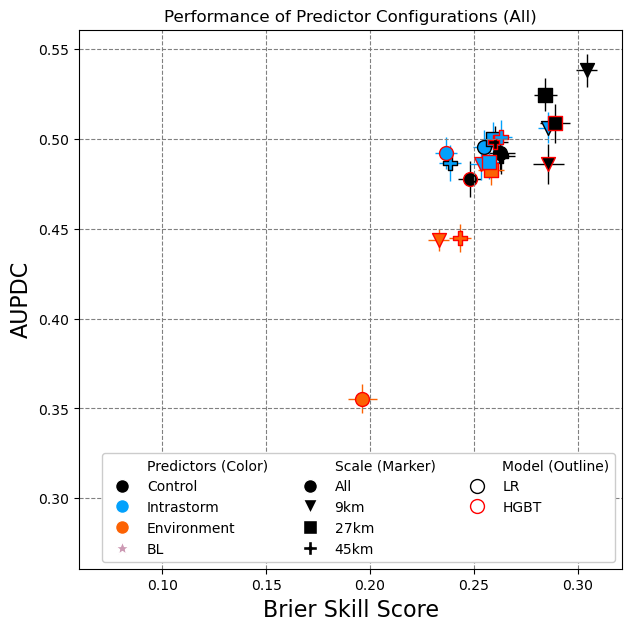

In [44]:
#One hazard
#Color: predictor category storm/env/all
#Marker: predictor neighborhood/all
fig, ax = plt.subplots(figsize=(7,7))


for (mod, score) in daily_scores[plot_date]: #final_mask_scores[p]: #_scores:
    if mod['hazard']==plot_haz:
        ax.errorbar(np.nanmean(score[x_met]),np.nanmean(score[y_met]), xerr=2*np.std(score[x_met]), yerr=2*np.std(score[y_met]), color=marker_colors[mod['suffix']], marker=None, linewidth=line_width, zorder=0)
        ax.scatter(np.nanmean(score[x_met]), np.nanmean(score[y_met]), color=marker_colors[mod['suffix']], marker=marker_shapes[mod['train']], s=size, edgecolor='red' if mod['name']=='hist' else 'k')

    else:
        pass
#Baseline
#ax.errorbar(np.nanmean(bl_scores[bl_inds[plot_haz]][x_met]),np.nanmean(bl_scores[bl_inds[plot_haz]][y_met]), xerr=2*np.std(bl_scores[bl_inds[plot_haz]][x_met]), yerr=2*np.std(bl_scores[bl_inds[plot_haz]][y_met]), color=(.8,.6,.7), marker=None, linewidth=line_width, zorder=0)
#ax.scatter(np.nanmean(bl_scores[bl_inds[plot_haz]][x_met]),np.nanmean(bl_scores[bl_inds[plot_haz]][y_met]), edgecolor='k', color=(.8,.6,.7), marker='*',  s=1.5*size)

ax.set_xlabel(met_labels[x_met], fontsize=16)
ax.set_ylabel(met_labels[y_met], fontsize=16)


#AX lims

if x_met in ['reliability','brier_loss','resolution','pph']:
    ax.set_xlim(0,0.01) if x_met=='reliability' else ax.set_xlim(0,0.1)
elif x_met=='auc':
    ax.set_xlim(0,1)
else:
    ax.set_xlim(0,0.4)

if y_met in ['reliability','brier_loss','resolution','pph']:
    ax.set_ylim(0,0.01) if y_met=='reliability' else ax.set_ylim(0,0.2)
elif y_met=='auc':
    ax.set_ylim(0,1)
elif y_met=='log_loss':
    ax.set_ylim(0,0.25)
else:
    ax.set_ylim(0,0.4)

ax.set_title(f'Performance of Predictor Configurations ({plot_haz.capitalize()})')# if plot_haz !="all" else "Any-Severe"}) (p >= {p:.2f})', fontsize=16)
ax.grid( color='grey', ls='--')


leg_handles=[]
leg_handles.append(Line2D([0],[0], marker='*',color='w',markerfacecolor='w', label='Predictors (Color)', markersize=10))
for mark in marker_colors.keys():
    if mark not in ['all','wind','hail','tornado']:
        leg_handles.append(Line2D([0],[0], marker='o',color='w',markerfacecolor=marker_colors[mark], label=mark.capitalize(), markersize=10))

leg_handles.append(Line2D([0],[0], marker='*',color='w',markerfacecolor=(0.8,0.6,0.7), label='BL', markersize=10))
leg_handles.append(Line2D([0],[0], marker='*',color='w',markerfacecolor='w', label='Scale (Marker)', markersize=10))
for mark in marker_shapes.keys():
    leg_handles.append(Line2D([0],[0], marker=marker_shapes[mark], markerfacecolor='k', color='w', label=mark.capitalize(), markersize=10))
    

leg_handles.append(Line2D([0],[0], marker=marker_shapes[mark], markerfacecolor='w', color='w', label='Model (Outline)', markersize=10))
leg_handles.append(Line2D([0],[0], marker='o', markeredgecolor='k', markerfacecolor='w', color='w', label='LR', markersize=10))
leg_handles.append(Line2D([0],[0], marker='o', markeredgecolor='red', markerfacecolor='w', color='w', label='HGBT', markersize=10))

leg_handles.append(Line2D([0],[0], marker=marker_shapes[mark], markerfacecolor='w', color='w', label='', markersize=10))
leg_handles.append(Line2D([0],[0], marker=marker_shapes[mark], markerfacecolor='w', color='w', label='', markersize=10))

if y_met in ['reliability', 'log_loss','brier_loss','bss','pph','resolution']:
    plt.legend(handles=leg_handles, ncol=3, loc='upper right', framealpha=1)
else:
    plt.legend(handles=leg_handles, ncol=3, loc='lower right', framealpha=1)  


plt.show()                                          

#Poor BSS is due to very high base rate?

# Peformance for each test case

In [45]:
max_scores=[]
bl_max_scores=[]
for day in list(daily_scores.keys()):
    #BL
    bl_max_scores.append((day, np.nanmean(bl_daily_scores[day][bl_inds[plot_haz]][x_met]), 2*np.std(bl_daily_scores[day][bl_inds[plot_haz]][x_met])))
    #ML
    daily_mean=[np.nanmean(score[x_met]) if mod['hazard']==plot_haz else np.nan for (mod, score) in daily_scores[day]]
    daily_std=[2*np.nanstd(score[x_met]) if mod['hazard']==plot_haz else np.nan for (mod, score) in daily_scores[day]]
    
    daily_max=np.nanmax(daily_mean) #Take the highest value
    try:
        daily_max_std=daily_std[np.nanargmax(daily_mean)] # get the associated std for the highest mean
    except ValueError:
        print('All NAN Slice')
        daily_max_std=np.nan
    
    base_rate=np.nanmean(y_dic[plot_haz][metadata.groupby(['Run Date']).get_group(str(day)).index.values])
    print(f'{day}: {base_rate}')
    max_scores.append((day, daily_max, daily_max_std, base_rate))
max_scores=np.array(max_scores) 
bl_max_scores=np.array(bl_max_scores)

20180511: 0.011337868480725623
20180514: 0.20904195011337867
20180521: 0.03784013605442177
20180531: 0.17616213151927437
20190501: 0.04387777777777778
20190502: 0.016677777777777777
20190508: 0.02772222222222222


/home/samuel.varga/miniconda3/envs/Vanilla/lib/python3.10/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/samuel.varga/miniconda3/envs/Vanilla/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


20190510: 0.0
20190515: 0.04555555555555556
20190520: 0.12173333333333333
20190521: 0.04984444444444444
20190523: 0.08606666666666667
20190526: 0.156


/home/samuel.varga/miniconda3/envs/Vanilla/lib/python3.10/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/samuel.varga/miniconda3/envs/Vanilla/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


20200506: 0.0
20200507: 0.0717090909090909
20200508: 0.0053625
20200519: 0.017390909090909092
20200529: 0.044427272727272725
20210504: 0.10076363636363636
20210507: 0.03364545454545455
20210510: 0.050954545454545454
20210513: 0.02421818181818182
20210520: 0.01880909090909091
20210521: 0.013818181818181818
20210523: 0.10298181818181819


In [46]:
def align_yaxis(axes): 
    '''Aligns axes of subplots. From: https://stackoverflow.com/questions/10481990/matplotlib-axis-with-two-scales-shared-origin'''
    y_lims = np.array([ax.get_ylim() for ax in axes])

    # force 0 to appear on all axes, comment if don't need
    y_lims[:, 0] = y_lims[:, 0].clip(None, 0)
    y_lims[:, 1] = y_lims[:, 1].clip(0, None)

    # normalize all axes
    y_mags = (y_lims[:,1] - y_lims[:,0]).reshape(len(y_lims),1)
    y_lims_normalized = y_lims / y_mags

    # find combined range
    y_new_lims_normalized = np.array([np.min(y_lims_normalized), np.max(y_lims_normalized)])

    # denormalize combined range to get new axes
    new_lims = y_new_lims_normalized * y_mags
    for i, ax in enumerate(axes):
        ax.set_ylim(new_lims[i]) 

/tmp/ipykernel_1558365/3592379014.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(max_scores[:,0][np.argsort(max_scores[:,1].astype('float'))], rotation=45, ha='right', fontsize=14)


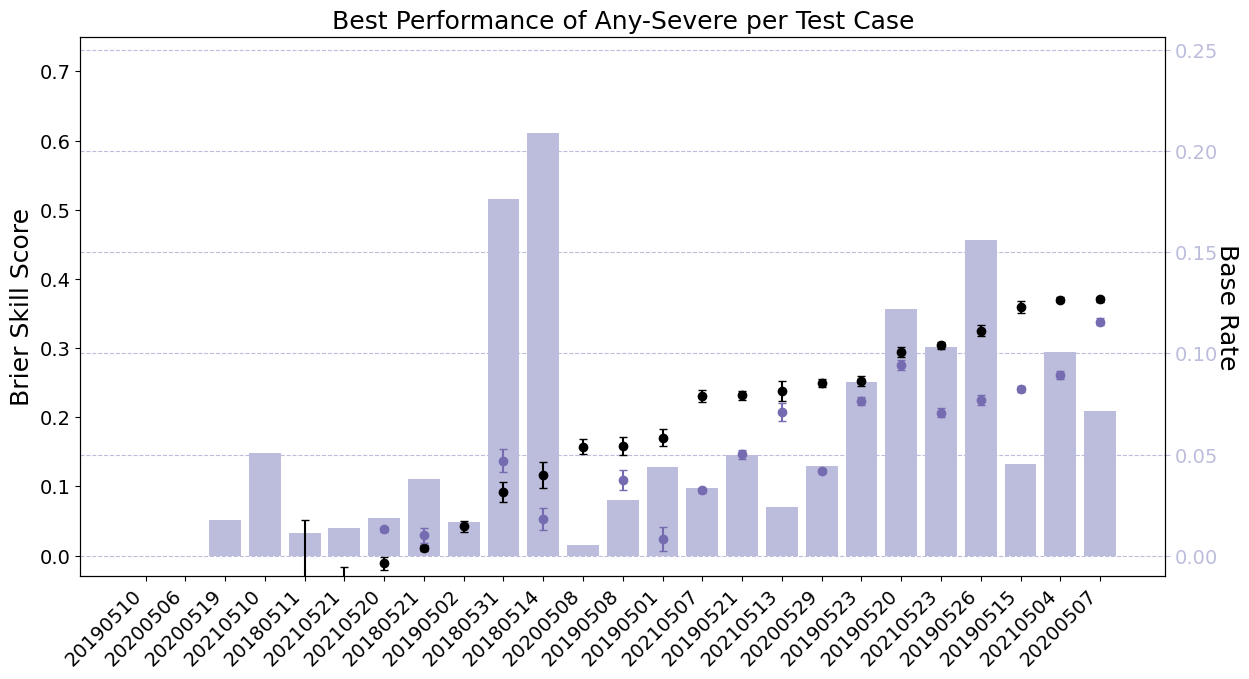

In [47]:
sortby='metric'

fig, ax = plt.subplots(figsize=(14,7))

if sortby=='date':
    ax2=ax.twinx()
    ax.bar(max_scores[:,0], max_scores[:,3].astype('float'), color='#bcbddc')
    
    ax2.scatter(max_scores[:,0], max_scores[:,1].astype('float'), color='k', zorder=4)
    ax2.errorbar(max_scores[:,0], max_scores[:,1].astype('float'), yerr=max_scores[:,2].astype('float'), marker=None, capsize=3, ls='none', zorder=3, color='k')
   
    ax.set_xticklabels(max_scores[:,0], rotation=45, ha='right', fontsize=14)
    
    #Baseline
    ax2.errorbar(bl_max_scores[:,0], bl_max_scores[:,1].astype('float'), yerr=bl_max_scores[:,2].astype('float'), color='#756bb1', capsize=3, marker=None, ls='none', zorder=3)
    ax2.scatter(bl_max_scores[:,0], bl_max_scores[:,1].astype('float'), color='#756bb1', zorder=4)
    
elif sortby=='metric':
    ax2=ax.twinx()
    
    ax2.scatter(max_scores[:,0][np.argsort(max_scores[:,1].astype('float'))], np.sort(max_scores[:,1].astype('float')), color='k')
    ax2.errorbar(max_scores[:,0][np.argsort(max_scores[:,1].astype('float'))], np.sort(max_scores[:,1].astype('float')), yerr=max_scores[:,2][np.argsort(max_scores[:,1].astype('float'))].astype('float'), marker=None, capsize=3, ls='none', zorder=0, color='k')
    
    ax.bar(max_scores[:,0][np.argsort(max_scores[:,1].astype('float'))], max_scores[:,3].astype('float')[np.argsort(max_scores[:,1].astype('float'))], color='#bcbddc')
    ax.set_xticklabels(max_scores[:,0][np.argsort(max_scores[:,1].astype('float'))], rotation=45, ha='right', fontsize=14)
    
    #Baseline
    ax2.errorbar(bl_max_scores[:,0][np.argsort(max_scores[:,1].astype('float'))], bl_max_scores[:,1].astype('float')[np.argsort(max_scores[:,1].astype('float'))], yerr=bl_max_scores[:,2][np.argsort(max_scores[:,1].astype('float'))].astype('float'), color='#756bb1', capsize=3, marker=None, ls='none', zorder=3)
    ax2.scatter(bl_max_scores[:,0][np.argsort(max_scores[:,1].astype('float'))], bl_max_scores[:,1].astype('float')[np.argsort(max_scores[:,1].astype('float'))], color='#756bb1', zorder=4)
    
elif sortby=='rate':
    ax2=ax.twinx()
    
    ax2.scatter(max_scores[:,0][np.argsort(max_scores[:,3].astype('float'))], max_scores[:,1].astype('float')[np.argsort(max_scores[:,3].astype('float'))], color='k')
    ax2.errorbar(max_scores[:,0][np.argsort(max_scores[:,3].astype('float'))], max_scores[:,1].astype('float')[np.argsort(max_scores[:,3].astype('float'))], yerr=max_scores[:,2][np.argsort(max_scores[:,3].astype('float'))].astype('float'), marker=None, capsize=3, ls='none', zorder=0, color='k')
    
    ax.bar(max_scores[:,0][np.argsort(max_scores[:,3].astype('float'))], np.sort(max_scores[:,3].astype('float')), color='#bcbddc')
    ax.set_xticklabels(max_scores[:,0][np.argsort(max_scores[:,3].astype('float'))], rotation=45, ha='right', fontsize=14)
    
    #Baseline
    ax2.errorbar(bl_max_scores[:,0][np.argsort(max_scores[:,3].astype('float'))], bl_max_scores[:,1].astype('float')[np.argsort(max_scores[:,3].astype('float'))], yerr=bl_max_scores[:,2].astype('float')[np.argsort(max_scores[:,3].astype('float'))], color='#756bb1', capsize=3, marker=None, ls='none', zorder=3)
    ax2.scatter(bl_max_scores[:,0][np.argsort(max_scores[:,3].astype('float'))], bl_max_scores[:,1].astype('float')[np.argsort(max_scores[:,3].astype('float'))], color='#756bb1', zorder=4)

elif sortby=='baseline':    
    ax2=ax.twinx()
    
    ax2.scatter(max_scores[:,0][np.argsort(bl_max_scores[:,1].astype('float'))], max_scores[:,1].astype('float')[np.argsort(bl_max_scores[:,1].astype('float'))], color='k')
    ax2.errorbar(max_scores[:,0][np.argsort(bl_max_scores[:,1].astype('float'))], max_scores[:,1].astype('float')[np.argsort(bl_max_scores[:,1].astype('float'))], yerr=max_scores[:,2][np.argsort(bl_max_scores[:,1].astype('float'))].astype('float'), marker=None, capsize=3, ls='none', zorder=0, color='k')
    
    ax.bar(max_scores[:,0][np.argsort(bl_max_scores[:,1].astype('float'))], max_scores[:,3].astype('float')[np.argsort(bl_max_scores[:,1].astype('float'))], color='#bcbddc')
    ax.set_xticklabels(max_scores[:,0][np.argsort(bl_max_scores[:,1].astype('float'))], rotation=45, ha='right', fontsize=14)
    
    #Baseline
    ax2.errorbar(bl_max_scores[:,0][np.argsort(bl_max_scores[:,1].astype('float'))], bl_max_scores[:,1].astype('float')[np.argsort(bl_max_scores[:,1].astype('float'))], yerr=bl_max_scores[:,2][np.argsort(max_scores[:,1].astype('float'))].astype('float'), color='#756bb1', capsize=3, marker=None, ls='none', zorder=3)
    ax2.scatter(bl_max_scores[:,0][np.argsort(bl_max_scores[:,1].astype('float'))], bl_max_scores[:,1].astype('float')[np.argsort(bl_max_scores[:,1].astype('float'))], color='#756bb1', zorder=4)
    
    
    
#Logistics
ax2.set_ylabel(met_labels[x_met], fontsize=18)
ax2.tick_params(labelsize=14)
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
ax.tick_params(labelsize=14)
ax2.set_xlabel('Run Date', fontsize=18)
ax.set_ylabel('Base Rate', fontsize=18, rotation=270, labelpad=15)
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')
ax.set_ylim(-0.01,0.25)
ax.tick_params(axis='y', labelcolor='#bcbddc', color='#bcbddc')
#ax.yaxis.label.set_color(color='#bcbddc')
ax2.set_ylim(-0.01,0.75)
ax.grid(ls='--', axis='y', color='#bcbddc')
align_yaxis([ax2,ax])
ax.set_title(f'Best Performance of {plot_haz.capitalize() if plot_haz!="all" else "Any-Severe"} per Test Case', fontsize=18)
plt.show()

# Metrics on One Test Case

In [ ]:
#Metric Exploration
data_base_path=f'/work/samuel.varga/data/{TIMESCALE}_hr_severe_wx/POTVIN/Single/2000'
X_, X_bl_, meta = load_ml_data(base_path=data_base_path, 
                       date='20190523',  
                       bl_column = get_bl_col('36',hazard+'_severe', TIMESCALE), FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE)

In [ ]:
_y_dic={}
group_inds=metadata.groupby(['Run Date', 'Init Time']).get_group(('20190523','2000')).index.values
for y, h in zip([y_all, y_wind, y_hail, y_torn], ['all','wind','hail','tornado']):
    _y_dic[h]=y[group_inds]


In [ ]:
X_=X_[[col for col in X_.columns if 'severe' not in col]]
_bl_scores=[]
for bl_mod, bl_X, h in zip(baseline_list, bl_df_list, ['all','wind','hail','tornado']):
    if h not in ['wind']:
        preds = get_bl_pred(X_bl_.values, ('BL',bl_mod))
        _bl_scores.append(sklearn_curve_bootstrap(_y_dic[h], preds, metric='reliability', pph=pph_dic[h][_y_dic[h]], n_boot=10, scorers=scorers, groups=None)[-1])
    else:
        pass

In [ ]:
_scores=[]
predlist=[]#Save these to a file
for mod_dic in mod_list:
    if mod_dic['hazard'] in ['wind']:
        pass
    else:
        X_s=Drop_Unwanted_Variables(X_, original=False, training_scale=None if mod_dic['train']=='all' else mod_dic['train'][0:-2:1], intrastormOnly=True if mod_dic['suffix']=='intrastorm' else False, envOnly=True if mod_dic['suffix']=='environment' else False)[0]
        #_scores.append((mod_dic, sklearn_curve_bootstrap(_y_dic[mod_dic['hazard']], get_ml_pred(X_s, mod_dic['model']), metric='reliability', pph=pph_dic[h][_y_dic[h]], n_boot=10, scorers=scorers, groups=None)[-1]))
        predlist.append((mod_dic, get_ml_pred(X_s, mod_dic['model'])))

In [ ]:
#Start where any/all is nonzero and targets are nonzero
final_mask_scores={}
X_s=Drop_Unwanted_Variables(X_, original=False, training_scale=None, intrastormOnly=False, envOnly=False)[0]
maskby_dic={'all':[_y_dic['all'], get_ml_pred(X_s, load_ml_model({'name':'logistic', 'train':'all', 'hazard':'all', 'targ_scale':'36km', 'suffix':'control'})['model'])],
                   'wind':[_y_dic['wind'], get_ml_pred(X_s, load_ml_model({'name':'logistic', 'train':'all', 'hazard':'wind', 'targ_scale':'36km', 'suffix':'control'})['model'])],
                   'hail':[_y_dic['hail'], get_ml_pred(X_s, load_ml_model({'name':'logistic', 'train':'all', 'hazard':'hail', 'targ_scale':'36km', 'suffix':'control'})['model'])],
                   'tornado':[_y_dic['tornado'], get_ml_pred(X_s, load_ml_model({'name':'logistic', 'train':'all', 'hazard':'tornado', 'targ_scale':'36km', 'suffix':'control'})['model'])]}


In [ ]:
for p in np.arange(0,1,0.05):
    final_mask_scores[p]=get_masked_percentile_metrics(predlist, p, maskby_dic, scorers=scorers, y_dic=_y_dic, cv=None, fname=None)
with open(join('/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/scores','Single.pkl'),'wb') as f:
    pickle.dump(final_mask_scores,  f)

In [ ]:
final_mask_scores[0.4]